In [0]:
#!python '/content/drive/My Drive/DL Internship/3DCNN/3dcnn.py' --batch 32 --epoch 1 --videos '/content/drive/My Drive/DL Internship/Dataset(videos)/cropped videos' --nclass 5 --output '/content/drive/My Drive/DL Internship/3DCNN/result' --color True --skip False --depth 10

In [0]:
import argparse
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, LSTM, Reshape, TimeDistributed,  GlobalAveragePooling1D, BatchNormalization)
#from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers.merge import Average
from keras.models import Model

from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import cv2
from easydict import EasyDict
%matplotlib inline

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        print("test ",filename)
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)

    def get_UCF_classname(self, filename):
        return filename[filename.find('_') + 1:filename.find('_', 2)]


In [0]:
def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, 'result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [0]:

def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=True):
    folders = os.listdir(video_dir)
    X = []
    labels = []
    labellist = []

    for folder in folders:
      files = os.listdir(video_dir+"/"+folder)
      pbar = tqdm(total=len(files))
      for filename in files:
          pbar.update(1)
          if filename == '.DS_Store':
              continue
          name = os.path.join(video_dir+"/"+folder, filename)
          # label = vid3d.get_UCF_classname(folder)
          label = folder
          if label not in labellist:
              if len(labellist) >= nclass:
                  continue
              labellist.append(label)
          labels.append(label)
          X.append(vid3d.video3d(name, color=color, skip=skip))

      pbar.close()
    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels


In [0]:
args = EasyDict({
    "batch": 32,
    "epoch": 500,
    "videos":'/content/drive/My Drive/Final Models/Merged  Dataset/dataset',
    "nclass":5,
    "color":True,
    "skip":False,
    "depth":12,
    "output": '/content/drive/My Drive/Final Models/2DCNN+LSTM/Result_new' 
})

In [34]:
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
fname_npz = args.output+'/dataset_{}_{}_{}.npz'.format(
    args.nclass, args.depth, args.skip)


vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = args.nclass
if os.path.exists(fname_npz):
    loadeddata = np.load(fname_npz)
    X, Y = loadeddata["X"], loadeddata["Y"]
else:
    x, y = loaddata(args.videos, vid3d, args.nclass,
                    args.output, args.color, args.skip)
    X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
    Y = np_utils.to_categorical(y, nb_classes)

    X = X.astype('float32')
    np.savez(fname_npz, X=X, Y=Y)
    print('Saved dataset to dataset.npz.')
print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))




  0%|          | 0/965 [00:00<?, ?it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_9.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_21.mp4





  0%|          | 3/965 [00:00<00:43, 22.06it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_12.mp4





  1%|          | 5/965 [00:00<00:49, 19.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_18.mp4





  1%|          | 7/965 [00:00<00:53, 17.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_8.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_29.mp4





  1%|          | 9/965 [00:00<00:57, 16.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_19.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_20.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_15.mp4





  1%|          | 11/965 [00:00<01:00, 15.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing067_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_18.mp4





  1%|▏         | 13/965 [00:00<01:04, 14.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_9.mp4





  2%|▏         | 15/965 [00:00<01:04, 14.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_12.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_17.mp4





  2%|▏         | 17/965 [00:01<01:02, 15.18it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_21.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_30.mp4





  2%|▏         | 19/965 [00:01<01:04, 14.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_5.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_9.mp4





  2%|▏         | 21/965 [00:01<01:08, 13.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_11.mp4





  2%|▏         | 23/965 [00:01<01:06, 14.07it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_21.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_18.mp4





  3%|▎         | 25/965 [00:01<01:07, 13.92it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_12.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_21.mp4





  3%|▎         | 27/965 [00:01<01:10, 13.26it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_19.mp4





  3%|▎         | 29/965 [00:01<01:05, 14.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_24.mp4





  3%|▎         | 31/965 [00:02<01:04, 14.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_24.mp4





  3%|▎         | 33/965 [00:02<01:03, 14.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing006_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing006_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing006_x264_26.mp4





  4%|▎         | 35/965 [00:02<01:07, 13.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_19.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_15.mp4





  4%|▍         | 37/965 [00:02<01:08, 13.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_26.mp4





  4%|▍         | 39/965 [00:02<01:04, 14.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_4.mp4





  4%|▍         | 41/965 [00:02<01:05, 14.01it/s]


  4%|▍         | 43/965 [00:02<01:03, 14.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing010_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_11.mp4





  5%|▍         | 45/965 [00:03<01:02, 14.62it/s]


  5%|▍         | 47/965 [00:03<00:58, 15.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_26.mp4





  5%|▌         | 49/965 [00:03<00:56, 16.28it/s]


  5%|▌         | 51/965 [00:03<00:53, 17.18it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_11.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_10.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_22.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_26.mp4





  5%|▌         | 53/965 [00:03<00:54, 16.69it/s]


  6%|▌         | 55/965 [00:03<00:55, 16.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_23.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_6.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_13.mp4





  6%|▌         | 57/965 [00:03<00:55, 16.30it/s]


  6%|▌         | 59/965 [00:03<00:56, 15.92it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_12.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_20.mp4





  6%|▋         | 61/965 [00:04<00:57, 15.85it/s]


  7%|▋         | 63/965 [00:04<00:57, 15.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_20.mp4





  7%|▋         | 65/965 [00:04<00:57, 15.66it/s]


  7%|▋         | 67/965 [00:04<00:58, 15.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing054_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_8.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_29.mp4





  7%|▋         | 69/965 [00:04<00:59, 15.17it/s]


  7%|▋         | 71/965 [00:04<00:55, 16.12it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_2.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_14.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_15.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing081_x264_16.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_18.mp4





  8%|▊         | 73/965 [00:04<00:54, 16.23it/s]


  8%|▊         | 75/965 [00:04<00:53, 16.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_15.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_23.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing024_x264_7.mp4





  8%|▊         | 77/965 [00:05<00:52, 16.77it/s]


  8%|▊         | 79/965 [00:05<00:51, 17.07it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_21.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_22.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing098_x264_31.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_29.mp4





  8%|▊         | 81/965 [00:05<00:53, 16.66it/s]


  9%|▊         | 83/965 [00:05<00:54, 16.16it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_20.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_30.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_4.mp4





  9%|▉         | 85/965 [00:05<00:55, 15.93it/s]


  9%|▉         | 87/965 [00:05<00:56, 15.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_16.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_19.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_5.mp4





  9%|▉         | 89/965 [00:05<00:59, 14.80it/s]


  9%|▉         | 91/965 [00:05<00:57, 15.07it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing101_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing101_x264_30.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_30.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_21.mp4





 10%|▉         | 93/965 [00:06<00:55, 15.81it/s]


 10%|▉         | 95/965 [00:06<00:54, 16.11it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_22.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_31.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_10.mp4





 10%|█         | 97/965 [00:06<00:55, 15.71it/s]


 10%|█         | 99/965 [00:06<00:53, 16.10it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_23.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_10.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_15.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_13.mp4





 10%|█         | 101/965 [00:06<00:52, 16.57it/s]


 11%|█         | 103/965 [00:06<00:53, 15.96it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_9.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_15.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing101_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_31.mp4





 11%|█         | 105/965 [00:06<00:52, 16.41it/s]


 11%|█         | 107/965 [00:06<00:50, 16.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_19.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_2.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_31.mp4





 11%|█▏        | 109/965 [00:07<00:50, 16.89it/s]


 12%|█▏        | 111/965 [00:07<00:51, 16.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_17.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_10.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_24.mp4





 12%|█▏        | 113/965 [00:07<00:52, 16.31it/s]


 12%|█▏        | 115/965 [00:07<00:51, 16.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_10.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_16.mp4





 12%|█▏        | 117/965 [00:07<00:51, 16.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_22.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_28.mp4





 12%|█▏        | 119/965 [00:07<00:55, 15.34it/s]


 13%|█▎        | 121/965 [00:07<00:52, 16.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_10.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_14.mp4





 13%|█▎        | 123/965 [00:07<00:53, 15.88it/s]


 13%|█▎        | 125/965 [00:08<00:51, 16.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_21.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_12.mp4





 13%|█▎        | 127/965 [00:08<00:49, 16.93it/s]


 13%|█▎        | 129/965 [00:08<00:47, 17.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_6.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_23.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_17.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_5.mp4





 14%|█▎        | 131/965 [00:08<00:50, 16.43it/s]


 14%|█▍        | 133/965 [00:08<00:54, 15.26it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_30.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_23.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_7.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_29.mp4





 14%|█▍        | 135/965 [00:08<00:52, 15.76it/s]


 14%|█▍        | 137/965 [00:08<00:52, 15.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_29.mp4





 14%|█▍        | 139/965 [00:08<00:52, 15.78it/s]


 15%|█▍        | 141/965 [00:09<00:49, 16.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_8.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_10.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_23.mp4





 15%|█▍        | 143/965 [00:09<00:52, 15.80it/s]


 15%|█▌        | 145/965 [00:09<00:52, 15.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_8.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_31.mp4





 15%|█▌        | 147/965 [00:09<00:54, 15.00it/s]


 15%|█▌        | 149/965 [00:09<00:51, 15.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_30.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_20.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_16.mp4





 16%|█▌        | 151/965 [00:09<00:55, 14.77it/s]


 16%|█▌        | 153/965 [00:09<00:55, 14.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_15.mp4





 16%|█▌        | 155/965 [00:09<00:56, 14.28it/s]


 16%|█▋        | 157/965 [00:10<00:55, 14.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_20.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing006_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_14.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_31.mp4





 16%|█▋        | 159/965 [00:10<00:52, 15.36it/s]


 17%|█▋        | 161/965 [00:10<00:48, 16.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_30.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_2.mp4





 17%|█▋        | 163/965 [00:10<00:49, 16.12it/s]


 17%|█▋        | 165/965 [00:10<00:50, 15.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_17.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_31.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_22.mp4





 17%|█▋        | 167/965 [00:10<00:49, 16.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_11.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_20.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_21.mp4





 18%|█▊        | 169/965 [00:10<00:51, 15.51it/s]


 18%|█▊        | 171/965 [00:10<00:49, 16.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_1.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_29.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_22.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_17.mp4





 18%|█▊        | 173/965 [00:11<00:46, 16.87it/s]


 18%|█▊        | 175/965 [00:11<00:45, 17.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_20.mp4





 18%|█▊        | 177/965 [00:11<00:46, 17.11it/s]


 19%|█▊        | 179/965 [00:11<00:46, 16.94it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_16.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing036_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing036_x264_21.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_21.mp4





 19%|█▉        | 181/965 [00:11<00:46, 16.88it/s]


 19%|█▉        | 183/965 [00:11<00:47, 16.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_15.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_19.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_26.mp4





 19%|█▉        | 185/965 [00:11<00:46, 16.61it/s]


 19%|█▉        | 187/965 [00:11<00:46, 16.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_9.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_16.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_7.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_7.mp4





 20%|█▉        | 189/965 [00:12<00:46, 16.62it/s]


 20%|█▉        | 191/965 [00:12<00:46, 16.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_7.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_31.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_22.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_12.mp4





 20%|██        | 193/965 [00:12<00:45, 16.86it/s]


 20%|██        | 195/965 [00:12<00:45, 16.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_18.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_17.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_19.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_8.mp4





 20%|██        | 197/965 [00:12<00:43, 17.57it/s]


 21%|██        | 199/965 [00:12<00:42, 18.04it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_28.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_30.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_27.mp4





 21%|██        | 201/965 [00:12<00:42, 18.18it/s]


 21%|██        | 203/965 [00:12<00:44, 17.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_4.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_16.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_25.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing024_x264_22.mp4





 21%|██        | 205/965 [00:12<00:45, 16.78it/s]


 21%|██▏       | 207/965 [00:13<00:45, 16.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_16.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_31.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_16.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_25.mp4





 22%|██▏       | 209/965 [00:13<00:46, 16.25it/s]


 22%|██▏       | 211/965 [00:13<00:46, 16.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_14.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_5.mp4





 22%|██▏       | 213/965 [00:13<00:46, 16.05it/s]


 22%|██▏       | 215/965 [00:13<00:46, 16.16it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_12.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_14.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_26.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_5.mp4





 22%|██▏       | 217/965 [00:13<00:46, 16.18it/s]


 23%|██▎       | 219/965 [00:13<00:47, 15.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_21.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_9.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_24.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_21.mp4





 23%|██▎       | 221/965 [00:13<00:45, 16.40it/s]


 23%|██▎       | 223/965 [00:14<00:48, 15.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_7.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_22.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_23.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_21.mp4





 23%|██▎       | 225/965 [00:14<02:07,  5.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing016_x264_27.mp4
test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_17.mp4





 24%|██▎       | 227/965 [00:15<03:14,  3.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_26.mp4





 24%|██▎       | 228/965 [00:16<03:36,  3.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_26.mp4





 24%|██▎       | 229/965 [00:16<04:04,  3.00it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_13.mp4





 24%|██▍       | 230/965 [00:17<04:13,  2.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_22.mp4





 24%|██▍       | 231/965 [00:17<04:22,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_29.mp4





 24%|██▍       | 232/965 [00:17<04:54,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_11.mp4





 24%|██▍       | 233/965 [00:18<04:46,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_25.mp4





 24%|██▍       | 234/965 [00:18<04:41,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_11.mp4





 24%|██▍       | 235/965 [00:19<04:36,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_6.mp4





 24%|██▍       | 236/965 [00:19<04:46,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_8.mp4





 25%|██▍       | 237/965 [00:19<04:51,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_22.mp4





 25%|██▍       | 238/965 [00:20<04:37,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_17.mp4





 25%|██▍       | 239/965 [00:20<04:33,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_19.mp4





 25%|██▍       | 240/965 [00:20<04:31,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_23.mp4





 25%|██▍       | 241/965 [00:21<04:32,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_22.mp4





 25%|██▌       | 242/965 [00:21<04:40,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_10.mp4





 25%|██▌       | 243/965 [00:22<05:34,  2.16it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_27.mp4





 25%|██▌       | 244/965 [00:22<05:13,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_11.mp4





 25%|██▌       | 245/965 [00:23<05:02,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_28.mp4





 25%|██▌       | 246/965 [00:23<05:10,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_19.mp4





 26%|██▌       | 247/965 [00:23<04:58,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_24.mp4





 26%|██▌       | 248/965 [00:24<05:14,  2.28it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_25.mp4





 26%|██▌       | 249/965 [00:24<05:28,  2.18it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_21.mp4





 26%|██▌       | 250/965 [00:25<05:20,  2.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_23.mp4





 26%|██▌       | 251/965 [00:25<05:16,  2.26it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_10.mp4





 26%|██▌       | 252/965 [00:26<04:59,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_2.mp4





 26%|██▌       | 253/965 [00:26<05:00,  2.37it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_17.mp4





 26%|██▋       | 254/965 [00:27<04:55,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_15.mp4





 26%|██▋       | 255/965 [00:27<04:44,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_25.mp4





 27%|██▋       | 256/965 [00:27<04:35,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_23.mp4





 27%|██▋       | 257/965 [00:28<04:53,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_19.mp4





 27%|██▋       | 258/965 [00:28<04:46,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_24.mp4





 27%|██▋       | 259/965 [00:28<04:33,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_11.mp4





 27%|██▋       | 260/965 [00:29<04:30,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_7.mp4





 27%|██▋       | 261/965 [00:29<04:25,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_10.mp4





 27%|██▋       | 262/965 [00:30<04:26,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing098_x264_30.mp4





 27%|██▋       | 263/965 [00:30<04:22,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing101_x264_26.mp4





 27%|██▋       | 264/965 [00:30<04:21,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_14.mp4





 27%|██▋       | 265/965 [00:31<04:18,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_5.mp4





 28%|██▊       | 266/965 [00:31<04:19,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing093_x264_19.mp4





 28%|██▊       | 267/965 [00:31<04:13,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_18.mp4





 28%|██▊       | 268/965 [00:32<04:25,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_19.mp4





 28%|██▊       | 269/965 [00:32<04:19,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_18.mp4





 28%|██▊       | 270/965 [00:33<04:27,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_7.mp4





 28%|██▊       | 271/965 [00:33<04:27,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_10.mp4





 28%|██▊       | 272/965 [00:33<04:27,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_15.mp4





 28%|██▊       | 273/965 [00:34<04:26,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_6.mp4





 28%|██▊       | 274/965 [00:34<04:32,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_4.mp4





 28%|██▊       | 275/965 [00:35<04:43,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_12.mp4





 29%|██▊       | 276/965 [00:35<05:53,  1.95it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_30.mp4





 29%|██▊       | 277/965 [00:36<05:22,  2.14it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_18.mp4





 29%|██▉       | 278/965 [00:36<05:06,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_2.mp4





 29%|██▉       | 279/965 [00:37<04:57,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_9.mp4





 29%|██▉       | 280/965 [00:37<04:49,  2.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_17.mp4





 29%|██▉       | 281/965 [00:37<04:39,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_12.mp4





 29%|██▉       | 282/965 [00:38<04:34,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_17.mp4





 29%|██▉       | 283/965 [00:38<04:41,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_7.mp4





 29%|██▉       | 284/965 [00:39<04:34,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_28.mp4





 30%|██▉       | 285/965 [00:39<04:47,  2.37it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_14.mp4





 30%|██▉       | 286/965 [00:39<04:31,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_14.mp4





 30%|██▉       | 287/965 [00:40<04:31,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_12.mp4





 30%|██▉       | 288/965 [00:40<04:37,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_31.mp4





 30%|██▉       | 289/965 [00:40<04:22,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_23.mp4





 30%|███       | 290/965 [00:41<04:12,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_19.mp4





 30%|███       | 291/965 [00:41<04:11,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_25.mp4





 30%|███       | 292/965 [00:42<04:08,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_20.mp4





 30%|███       | 293/965 [00:42<04:11,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_13.mp4





 30%|███       | 294/965 [00:43<05:01,  2.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_6.mp4





 31%|███       | 295/965 [00:43<04:40,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_25.mp4





 31%|███       | 296/965 [00:43<04:32,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_13.mp4





 31%|███       | 297/965 [00:44<04:22,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_2.mp4





 31%|███       | 298/965 [00:44<04:19,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_31.mp4





 31%|███       | 299/965 [00:44<04:18,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_0.mp4





 31%|███       | 300/965 [00:45<04:18,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_29.mp4





 31%|███       | 301/965 [00:45<04:09,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_7.mp4





 31%|███▏      | 302/965 [00:46<04:19,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_28.mp4





 31%|███▏      | 303/965 [00:46<03:56,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_23.mp4





 32%|███▏      | 304/965 [00:46<03:56,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_15.mp4





 32%|███▏      | 305/965 [00:47<04:00,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_19.mp4





 32%|███▏      | 306/965 [00:47<04:15,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_17.mp4





 32%|███▏      | 307/965 [00:47<04:25,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_8.mp4





 32%|███▏      | 308/965 [00:48<04:21,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_6.mp4





 32%|███▏      | 309/965 [00:48<04:08,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_13.mp4





 32%|███▏      | 310/965 [00:49<04:10,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_18.mp4





 32%|███▏      | 311/965 [00:49<04:12,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_16.mp4





 32%|███▏      | 312/965 [00:49<04:08,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_9.mp4





 32%|███▏      | 313/965 [00:50<04:09,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_31.mp4





 33%|███▎      | 314/965 [00:50<03:57,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_17.mp4





 33%|███▎      | 315/965 [00:50<04:07,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_6.mp4





 33%|███▎      | 316/965 [00:51<04:10,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_30.mp4





 33%|███▎      | 317/965 [00:51<04:09,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_25.mp4





 33%|███▎      | 318/965 [00:52<04:03,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_17.mp4





 33%|███▎      | 319/965 [00:52<04:00,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_6.mp4





 33%|███▎      | 320/965 [00:52<03:59,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_10.mp4





 33%|███▎      | 321/965 [00:53<03:49,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_3.mp4





 33%|███▎      | 322/965 [00:53<03:53,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_20.mp4





 33%|███▎      | 323/965 [00:53<04:01,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_26.mp4





 34%|███▎      | 324/965 [00:54<04:00,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_15.mp4





 34%|███▎      | 325/965 [00:54<04:00,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_30.mp4





 34%|███▍      | 326/965 [00:55<03:57,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_12.mp4





 34%|███▍      | 327/965 [00:55<03:53,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_27.mp4





 34%|███▍      | 328/965 [00:55<04:11,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_20.mp4





 34%|███▍      | 329/965 [00:56<04:06,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_13.mp4





 34%|███▍      | 330/965 [00:56<04:10,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_31.mp4





 34%|███▍      | 331/965 [00:57<04:09,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_29.mp4





 34%|███▍      | 332/965 [00:57<04:12,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_21.mp4





 35%|███▍      | 333/965 [00:57<04:04,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_27.mp4





 35%|███▍      | 334/965 [00:58<04:30,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_8.mp4





 35%|███▍      | 335/965 [00:58<04:20,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing098_x264_28.mp4





 35%|███▍      | 336/965 [00:59<04:11,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_24.mp4





 35%|███▍      | 337/965 [00:59<04:09,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_19.mp4





 35%|███▌      | 338/965 [00:59<04:02,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_6.mp4





 35%|███▌      | 339/965 [01:00<03:51,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_28.mp4





 35%|███▌      | 340/965 [01:00<03:52,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_30.mp4





 35%|███▌      | 341/965 [01:01<04:05,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_31.mp4





 35%|███▌      | 342/965 [01:01<04:03,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_16.mp4





 36%|███▌      | 343/965 [01:01<03:55,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_13.mp4





 36%|███▌      | 344/965 [01:02<04:00,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_12.mp4





 36%|███▌      | 345/965 [01:02<03:51,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_13.mp4





 36%|███▌      | 346/965 [01:02<03:44,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_15.mp4





 36%|███▌      | 347/965 [01:03<03:50,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_23.mp4





 36%|███▌      | 348/965 [01:03<03:50,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_16.mp4





 36%|███▌      | 349/965 [01:04<03:57,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_22.mp4





 36%|███▋      | 350/965 [01:04<03:56,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_12.mp4





 36%|███▋      | 351/965 [01:04<03:55,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_18.mp4





 36%|███▋      | 352/965 [01:05<04:16,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_27.mp4





 37%|███▋      | 353/965 [01:05<04:22,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_8.mp4





 37%|███▋      | 354/965 [01:06<04:12,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_4.mp4





 37%|███▋      | 355/965 [01:06<04:10,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_25.mp4





 37%|███▋      | 356/965 [01:06<03:57,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_5.mp4





 37%|███▋      | 357/965 [01:07<04:13,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_25.mp4





 37%|███▋      | 358/965 [01:07<04:11,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_27.mp4





 37%|███▋      | 359/965 [01:08<03:59,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_23.mp4





 37%|███▋      | 360/965 [01:08<03:47,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing007_x264_25.mp4





 37%|███▋      | 361/965 [01:09<05:42,  1.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing006_x264_31.mp4





 38%|███▊      | 362/965 [01:10<05:57,  1.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_16.mp4





 38%|███▊      | 363/965 [01:10<05:15,  1.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_28.mp4





 38%|███▊      | 364/965 [01:10<04:43,  2.12it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_31.mp4





 38%|███▊      | 365/965 [01:11<04:24,  2.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_3.mp4





 38%|███▊      | 366/965 [01:11<04:22,  2.28it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_16.mp4





 38%|███▊      | 367/965 [01:12<04:22,  2.28it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_15.mp4





 38%|███▊      | 368/965 [01:12<04:30,  2.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_29.mp4





 38%|███▊      | 369/965 [01:12<04:17,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_8.mp4





 38%|███▊      | 370/965 [01:13<04:02,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_26.mp4





 38%|███▊      | 371/965 [01:13<04:24,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_25.mp4





 39%|███▊      | 372/965 [01:14<04:09,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_19.mp4





 39%|███▊      | 373/965 [01:14<04:08,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_29.mp4





 39%|███▉      | 374/965 [01:14<03:52,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_1.mp4





 39%|███▉      | 375/965 [01:15<03:54,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_25.mp4





 39%|███▉      | 376/965 [01:15<04:08,  2.37it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_28.mp4





 39%|███▉      | 377/965 [01:16<03:59,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_19.mp4





 39%|███▉      | 378/965 [01:16<04:00,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_5.mp4





 39%|███▉      | 379/965 [01:17<04:03,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_9.mp4





 39%|███▉      | 380/965 [01:17<04:15,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_9.mp4





 39%|███▉      | 381/965 [01:17<04:23,  2.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_18.mp4





 40%|███▉      | 382/965 [01:18<04:21,  2.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_27.mp4





 40%|███▉      | 383/965 [01:18<04:12,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_11.mp4





 40%|███▉      | 384/965 [01:19<04:04,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_15.mp4





 40%|███▉      | 385/965 [01:19<03:55,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_17.mp4





 40%|████      | 386/965 [01:19<03:54,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_28.mp4





 40%|████      | 387/965 [01:20<03:42,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_3.mp4





 40%|████      | 388/965 [01:20<03:36,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_19.mp4





 40%|████      | 389/965 [01:21<03:38,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_15.mp4





 40%|████      | 390/965 [01:21<03:55,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_17.mp4





 41%|████      | 391/965 [01:21<03:51,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_23.mp4





 41%|████      | 392/965 [01:22<03:39,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_20.mp4





 41%|████      | 393/965 [01:22<03:43,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing024_x264_8.mp4





 41%|████      | 394/965 [01:23<03:43,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_13.mp4





 41%|████      | 395/965 [01:23<03:35,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_10.mp4





 41%|████      | 396/965 [01:23<03:30,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_20.mp4





 41%|████      | 397/965 [01:24<03:36,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_20.mp4





 41%|████      | 398/965 [01:24<03:38,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_23.mp4





 41%|████▏     | 399/965 [01:24<03:32,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_18.mp4





 41%|████▏     | 400/965 [01:25<03:33,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_30.mp4





 42%|████▏     | 401/965 [01:25<03:36,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_11.mp4





 42%|████▏     | 402/965 [01:26<03:34,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_22.mp4





 42%|████▏     | 403/965 [01:26<03:33,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_3.mp4





 42%|████▏     | 404/965 [01:26<03:32,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_0.mp4





 42%|████▏     | 405/965 [01:27<03:31,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing036_x264_23.mp4





 42%|████▏     | 406/965 [01:27<03:28,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_28.mp4





 42%|████▏     | 407/965 [01:27<03:29,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_9.mp4





 42%|████▏     | 408/965 [01:28<03:21,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_22.mp4





 42%|████▏     | 409/965 [01:28<03:23,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_13.mp4





 42%|████▏     | 410/965 [01:29<03:18,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_14.mp4





 43%|████▎     | 411/965 [01:29<03:17,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_24.mp4





 43%|████▎     | 412/965 [01:29<03:34,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_11.mp4





 43%|████▎     | 413/965 [01:30<03:37,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_17.mp4





 43%|████▎     | 414/965 [01:30<03:38,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_27.mp4





 43%|████▎     | 415/965 [01:31<03:34,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_26.mp4





 43%|████▎     | 416/965 [01:31<03:32,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_28.mp4





 43%|████▎     | 417/965 [01:31<03:34,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_10.mp4





 43%|████▎     | 418/965 [01:32<03:41,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_23.mp4





 43%|████▎     | 419/965 [01:32<03:39,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_18.mp4





 44%|████▎     | 420/965 [01:33<03:42,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_30.mp4





 44%|████▎     | 421/965 [01:33<03:37,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_22.mp4





 44%|████▎     | 422/965 [01:33<03:37,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_11.mp4





 44%|████▍     | 423/965 [01:34<03:33,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_9.mp4





 44%|████▍     | 424/965 [01:34<03:47,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing010_x264_31.mp4





 44%|████▍     | 425/965 [01:35<03:46,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_24.mp4





 44%|████▍     | 426/965 [01:35<03:39,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_22.mp4





 44%|████▍     | 427/965 [01:36<04:08,  2.16it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_29.mp4





 44%|████▍     | 428/965 [01:36<04:14,  2.11it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_18.mp4





 44%|████▍     | 429/965 [01:36<04:03,  2.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_2.mp4





 45%|████▍     | 430/965 [01:37<03:48,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_22.mp4





 45%|████▍     | 431/965 [01:37<03:44,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_21.mp4





 45%|████▍     | 432/965 [01:38<03:49,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_29.mp4





 45%|████▍     | 433/965 [01:38<03:51,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing003_x264_27.mp4





 45%|████▍     | 434/965 [01:39<03:47,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_14.mp4





 45%|████▌     | 435/965 [01:39<03:41,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_25.mp4





 45%|████▌     | 436/965 [01:39<03:40,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_22.mp4





 45%|████▌     | 437/965 [01:40<03:48,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_19.mp4





 45%|████▌     | 438/965 [01:40<03:37,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_5.mp4





 45%|████▌     | 439/965 [01:41<03:31,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_26.mp4





 46%|████▌     | 440/965 [01:41<03:29,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing015_x264_26.mp4





 46%|████▌     | 441/965 [01:41<03:30,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_30.mp4





 46%|████▌     | 442/965 [01:42<03:23,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_23.mp4





 46%|████▌     | 443/965 [01:42<03:26,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing003_x264_28.mp4





 46%|████▌     | 444/965 [01:43<03:21,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing007_x264_22.mp4





 46%|████▌     | 445/965 [01:43<03:17,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing007_x264_24.mp4





 46%|████▌     | 446/965 [01:43<03:14,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_12.mp4





 46%|████▋     | 447/965 [01:44<03:11,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_11.mp4





 46%|████▋     | 448/965 [01:44<03:11,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_21.mp4





 47%|████▋     | 449/965 [01:44<03:22,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_20.mp4





 47%|████▋     | 450/965 [01:45<03:33,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_10.mp4





 47%|████▋     | 451/965 [01:45<03:35,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing010_x264_30.mp4





 47%|████▋     | 452/965 [01:46<03:33,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_7.mp4





 47%|████▋     | 453/965 [01:46<03:32,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_13.mp4





 47%|████▋     | 454/965 [01:47<03:43,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_29.mp4





 47%|████▋     | 455/965 [01:47<03:28,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_21.mp4





 47%|████▋     | 456/965 [01:47<03:31,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing007_x264_26.mp4





 47%|████▋     | 457/965 [01:48<03:19,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_24.mp4





 47%|████▋     | 458/965 [01:48<03:17,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing003_x264_29.mp4





 48%|████▊     | 459/965 [01:49<03:16,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_24.mp4





 48%|████▊     | 460/965 [01:49<03:15,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing007_x264_23.mp4





 48%|████▊     | 461/965 [01:49<03:16,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_16.mp4





 48%|████▊     | 462/965 [01:50<03:16,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_8.mp4





 48%|████▊     | 463/965 [01:50<03:23,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_27.mp4





 48%|████▊     | 464/965 [01:51<03:21,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_13.mp4





 48%|████▊     | 465/965 [01:51<03:13,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing014_x264_3.mp4





 48%|████▊     | 466/965 [01:51<03:19,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_21.mp4





 48%|████▊     | 467/965 [01:52<03:18,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_3.mp4





 48%|████▊     | 468/965 [01:52<03:12,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_22.mp4





 49%|████▊     | 469/965 [01:52<03:06,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing006_x264_30.mp4





 49%|████▊     | 470/965 [01:53<03:11,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_1.mp4





 49%|████▉     | 471/965 [01:53<03:18,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_19.mp4





 49%|████▉     | 472/965 [01:54<03:22,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_17.mp4





 49%|████▉     | 473/965 [01:54<03:16,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing016_x264_28.mp4





 49%|████▉     | 474/965 [01:54<03:14,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_19.mp4





 49%|████▉     | 475/965 [01:55<03:17,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing017_x264_20.mp4





 49%|████▉     | 476/965 [01:55<03:28,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_4.mp4





 49%|████▉     | 477/965 [01:56<03:30,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing007_x264_27.mp4





 50%|████▉     | 478/965 [01:56<03:21,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_23.mp4





 50%|████▉     | 479/965 [01:57<03:25,  2.37it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing009_x264_31.mp4





 50%|████▉     | 480/965 [01:57<03:13,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing002_x264_18.mp4





 50%|████▉     | 481/965 [01:57<03:17,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing011_x264_30.mp4





 50%|████▉     | 482/965 [01:58<03:10,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing008_x264_20.mp4





 50%|█████     | 483/965 [01:58<03:06,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_0.mp4





 50%|█████     | 484/965 [01:58<03:03,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_17.mp4





 50%|█████     | 485/965 [01:59<02:57,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_24.mp4





 50%|█████     | 486/965 [01:59<02:59,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_24.mp4





 50%|█████     | 487/965 [02:00<03:26,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing036_x264_22.mp4





 51%|█████     | 488/965 [02:00<03:16,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_13.mp4





 51%|█████     | 489/965 [02:00<03:06,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_17.mp4





 51%|█████     | 490/965 [02:01<03:03,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_28.mp4





 51%|█████     | 491/965 [02:01<03:01,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_12.mp4





 51%|█████     | 492/965 [02:02<03:04,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_22.mp4





 51%|█████     | 493/965 [02:02<03:34,  2.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_21.mp4





 51%|█████     | 494/965 [02:03<03:34,  2.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing024_x264_6.mp4





 51%|█████▏    | 495/965 [02:03<03:23,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_20.mp4





 51%|█████▏    | 496/965 [02:03<03:11,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_21.mp4





 52%|█████▏    | 497/965 [02:04<03:23,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_28.mp4





 52%|█████▏    | 498/965 [02:04<03:12,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_14.mp4





 52%|█████▏    | 499/965 [02:05<03:13,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_21.mp4





 52%|█████▏    | 500/965 [02:05<03:18,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_27.mp4





 52%|█████▏    | 501/965 [02:06<03:10,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_19.mp4





 52%|█████▏    | 502/965 [02:06<03:09,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_9.mp4





 52%|█████▏    | 503/965 [02:06<03:04,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_20.mp4





 52%|█████▏    | 504/965 [02:07<02:56,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_1.mp4





 52%|█████▏    | 505/965 [02:07<03:18,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_11.mp4





 52%|█████▏    | 506/965 [02:08<03:07,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_18.mp4





 53%|█████▎    | 507/965 [02:08<02:59,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_6.mp4





 53%|█████▎    | 508/965 [02:08<02:55,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_17.mp4





 53%|█████▎    | 509/965 [02:09<03:00,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_24.mp4





 53%|█████▎    | 510/965 [02:09<03:09,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_25.mp4





 53%|█████▎    | 511/965 [02:09<02:56,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing024_x264_20.mp4





 53%|█████▎    | 512/965 [02:10<02:51,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_23.mp4





 53%|█████▎    | 513/965 [02:10<02:53,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_13.mp4





 53%|█████▎    | 514/965 [02:11<02:54,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_27.mp4





 53%|█████▎    | 515/965 [02:11<02:50,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_29.mp4





 53%|█████▎    | 516/965 [02:11<02:57,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_8.mp4





 54%|█████▎    | 517/965 [02:12<02:52,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_27.mp4





 54%|█████▎    | 518/965 [02:12<02:43,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_25.mp4





 54%|█████▍    | 519/965 [02:12<02:43,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_10.mp4





 54%|█████▍    | 520/965 [02:13<02:55,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_2.mp4





 54%|█████▍    | 521/965 [02:13<02:49,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_13.mp4





 54%|█████▍    | 522/965 [02:14<02:46,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_23.mp4





 54%|█████▍    | 523/965 [02:14<02:47,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_27.mp4





 54%|█████▍    | 524/965 [02:14<02:53,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_15.mp4





 54%|█████▍    | 525/965 [02:15<02:50,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_8.mp4





 55%|█████▍    | 526/965 [02:15<02:58,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_22.mp4





 55%|█████▍    | 527/965 [02:16<02:58,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_15.mp4





 55%|█████▍    | 528/965 [02:16<02:53,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_27.mp4





 55%|█████▍    | 529/965 [02:16<02:48,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_29.mp4





 55%|█████▍    | 530/965 [02:17<02:44,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing036_x264_24.mp4





 55%|█████▌    | 531/965 [02:17<03:06,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_30.mp4





 55%|█████▌    | 532/965 [02:18<02:59,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_4.mp4





 55%|█████▌    | 533/965 [02:18<02:52,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_26.mp4





 55%|█████▌    | 534/965 [02:18<02:45,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_29.mp4





 55%|█████▌    | 535/965 [02:19<02:42,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_19.mp4





 56%|█████▌    | 536/965 [02:19<02:37,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing026_x264_26.mp4





 56%|█████▌    | 537/965 [02:19<02:35,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_9.mp4





 56%|█████▌    | 538/965 [02:20<02:35,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_20.mp4





 56%|█████▌    | 539/965 [02:20<02:31,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_19.mp4





 56%|█████▌    | 540/965 [02:21<02:36,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing024_x264_21.mp4





 56%|█████▌    | 541/965 [02:21<02:35,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_12.mp4





 56%|█████▌    | 542/965 [02:21<02:35,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_16.mp4





 56%|█████▋    | 543/965 [02:22<02:32,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_30.mp4





 56%|█████▋    | 544/965 [02:22<02:46,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing021_x264_7.mp4





 56%|█████▋    | 545/965 [02:23<02:40,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_6.mp4





 57%|█████▋    | 546/965 [02:23<02:36,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_26.mp4





 57%|█████▋    | 547/965 [02:23<02:30,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_31.mp4





 57%|█████▋    | 548/965 [02:24<02:30,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_10.mp4





 57%|█████▋    | 549/965 [02:24<02:35,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_21.mp4





 57%|█████▋    | 550/965 [02:24<02:34,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing022_x264_22.mp4





 57%|█████▋    | 551/965 [02:25<02:32,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing018_x264_14.mp4





 57%|█████▋    | 552/965 [02:25<02:36,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_25.mp4





 57%|█████▋    | 553/965 [02:25<02:36,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing027_x264_24.mp4





 57%|█████▋    | 554/965 [02:26<02:32,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing023_x264_14.mp4





 58%|█████▊    | 555/965 [02:26<02:27,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_16.mp4





 58%|█████▊    | 556/965 [02:27<02:38,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_6.mp4





 58%|█████▊    | 557/965 [02:27<02:35,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_12.mp4





 58%|█████▊    | 558/965 [02:27<02:35,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_20.mp4





 58%|█████▊    | 559/965 [02:28<02:31,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_7.mp4





 58%|█████▊    | 560/965 [02:28<02:26,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_22.mp4





 58%|█████▊    | 561/965 [02:28<02:27,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_6.mp4





 58%|█████▊    | 562/965 [02:29<02:31,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_20.mp4





 58%|█████▊    | 563/965 [02:29<02:40,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_12.mp4





 58%|█████▊    | 564/965 [02:30<02:39,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_23.mp4





 59%|█████▊    | 565/965 [02:30<02:50,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_1.mp4





 59%|█████▊    | 566/965 [02:31<02:42,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_13.mp4





 59%|█████▉    | 567/965 [02:31<02:44,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_15.mp4





 59%|█████▉    | 568/965 [02:31<02:39,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_17.mp4





 59%|█████▉    | 569/965 [02:32<02:37,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_19.mp4





 59%|█████▉    | 570/965 [02:32<02:27,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_14.mp4





 59%|█████▉    | 571/965 [02:32<02:21,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_20.mp4





 59%|█████▉    | 572/965 [02:33<02:17,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_24.mp4





 59%|█████▉    | 573/965 [02:33<02:24,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_27.mp4





 59%|█████▉    | 574/965 [02:33<02:23,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_11.mp4





 60%|█████▉    | 575/965 [02:34<02:24,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_25.mp4





 60%|█████▉    | 576/965 [02:34<02:29,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_11.mp4





 60%|█████▉    | 577/965 [02:35<02:26,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_11.mp4





 60%|█████▉    | 578/965 [02:35<02:27,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_30.mp4





 60%|██████    | 579/965 [02:35<02:27,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_23.mp4





 60%|██████    | 580/965 [02:36<02:23,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_25.mp4





 60%|██████    | 581/965 [02:36<02:24,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_7.mp4





 60%|██████    | 582/965 [02:37<02:28,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_19.mp4





 60%|██████    | 583/965 [02:37<02:31,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_29.mp4





 61%|██████    | 584/965 [02:37<02:27,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_30.mp4





 61%|██████    | 585/965 [02:38<02:24,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_25.mp4





 61%|██████    | 586/965 [02:38<02:19,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_26.mp4





 61%|██████    | 587/965 [02:38<02:22,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_22.mp4





 61%|██████    | 588/965 [02:39<02:20,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_3.mp4





 61%|██████    | 589/965 [02:39<02:18,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_4.mp4





 61%|██████    | 590/965 [02:40<02:21,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_28.mp4





 61%|██████    | 591/965 [02:40<02:26,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_25.mp4





 61%|██████▏   | 592/965 [02:40<02:25,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_21.mp4





 61%|██████▏   | 593/965 [02:41<02:25,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_18.mp4





 62%|██████▏   | 594/965 [02:41<02:20,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_23.mp4





 62%|██████▏   | 595/965 [02:41<02:14,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_20.mp4





 62%|██████▏   | 596/965 [02:42<02:09,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_24.mp4





 62%|██████▏   | 597/965 [02:42<02:11,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing047_x264_21.mp4





 62%|██████▏   | 598/965 [02:42<02:11,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_18.mp4





 62%|██████▏   | 599/965 [02:43<02:11,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_26.mp4





 62%|██████▏   | 600/965 [02:45<04:34,  1.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_1.mp4





 62%|██████▏   | 601/965 [02:45<04:07,  1.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_10.mp4





 62%|██████▏   | 602/965 [02:45<03:31,  1.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_31.mp4





 62%|██████▏   | 603/965 [02:46<03:28,  1.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_18.mp4





 63%|██████▎   | 604/965 [02:46<03:06,  1.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_15.mp4





 63%|██████▎   | 605/965 [02:47<02:54,  2.06it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_23.mp4





 63%|██████▎   | 606/965 [02:47<02:34,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_31.mp4





 63%|██████▎   | 607/965 [02:47<02:27,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_3.mp4





 63%|██████▎   | 608/965 [02:48<02:27,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_10.mp4





 63%|██████▎   | 609/965 [02:48<02:20,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_28.mp4





 63%|██████▎   | 610/965 [02:49<02:13,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_22.mp4





 63%|██████▎   | 611/965 [02:49<02:12,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing044_x264_2.mp4





 63%|██████▎   | 612/965 [02:49<02:15,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing037_x264_30.mp4





 64%|██████▎   | 613/965 [02:50<02:16,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing042_x264_5.mp4





 64%|██████▎   | 614/965 [02:50<02:15,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing049_x264_12.mp4





 64%|██████▎   | 615/965 [02:50<02:15,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_13.mp4





 64%|██████▍   | 616/965 [02:51<02:12,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_18.mp4





 64%|██████▍   | 617/965 [02:51<02:13,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_12.mp4





 64%|██████▍   | 618/965 [02:52<02:10,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing050_x264_28.mp4





 64%|██████▍   | 619/965 [02:52<02:10,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_15.mp4





 64%|██████▍   | 620/965 [02:52<02:16,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_14.mp4





 64%|██████▍   | 621/965 [02:53<02:15,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_17.mp4





 64%|██████▍   | 622/965 [02:53<02:17,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_20.mp4





 65%|██████▍   | 623/965 [02:54<02:12,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_19.mp4





 65%|██████▍   | 624/965 [02:54<02:06,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_21.mp4





 65%|██████▍   | 625/965 [02:54<02:06,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_8.mp4





 65%|██████▍   | 626/965 [02:55<02:12,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_22.mp4





 65%|██████▍   | 627/965 [02:55<02:12,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_30.mp4





 65%|██████▌   | 628/965 [02:55<02:10,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_30.mp4





 65%|██████▌   | 629/965 [02:56<02:08,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_8.mp4





 65%|██████▌   | 630/965 [02:56<02:08,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_29.mp4





 65%|██████▌   | 631/965 [02:57<02:15,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_9.mp4





 65%|██████▌   | 632/965 [02:57<02:09,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing054_x264_31.mp4





 66%|██████▌   | 633/965 [02:57<02:06,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_7.mp4





 66%|██████▌   | 634/965 [02:58<02:07,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_24.mp4





 66%|██████▌   | 635/965 [02:58<02:06,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_10.mp4





 66%|██████▌   | 636/965 [02:59<02:05,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_5.mp4





 66%|██████▌   | 637/965 [02:59<02:04,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_16.mp4





 66%|██████▌   | 638/965 [02:59<02:06,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_25.mp4





 66%|██████▌   | 639/965 [03:00<02:00,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_27.mp4





 66%|██████▋   | 640/965 [03:00<01:57,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_13.mp4





 66%|██████▋   | 641/965 [03:00<02:03,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_27.mp4





 67%|██████▋   | 642/965 [03:01<02:02,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_13.mp4





 67%|██████▋   | 643/965 [03:01<01:58,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_25.mp4





 67%|██████▋   | 644/965 [03:01<01:54,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_26.mp4





 67%|██████▋   | 645/965 [03:02<01:53,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing067_x264_17.mp4





 67%|██████▋   | 646/965 [03:02<01:53,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_12.mp4





 67%|██████▋   | 647/965 [03:03<02:19,  2.28it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_21.mp4





 67%|██████▋   | 648/965 [03:03<02:10,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_27.mp4





 67%|██████▋   | 649/965 [03:04<02:08,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_21.mp4





 67%|██████▋   | 650/965 [03:04<02:06,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_19.mp4





 67%|██████▋   | 651/965 [03:04<02:06,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_20.mp4





 68%|██████▊   | 652/965 [03:05<02:03,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_9.mp4





 68%|██████▊   | 653/965 [03:05<01:58,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_21.mp4





 68%|██████▊   | 654/965 [03:05<01:59,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_15.mp4





 68%|██████▊   | 655/965 [03:06<01:56,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_15.mp4





 68%|██████▊   | 656/965 [03:06<01:55,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_28.mp4





 68%|██████▊   | 657/965 [03:07<01:53,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_30.mp4





 68%|██████▊   | 658/965 [03:07<01:52,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_28.mp4





 68%|██████▊   | 659/965 [03:07<01:48,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_17.mp4





 68%|██████▊   | 660/965 [03:08<01:47,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_31.mp4





 68%|██████▊   | 661/965 [03:08<01:53,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_26.mp4





 69%|██████▊   | 662/965 [03:08<01:54,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_27.mp4





 69%|██████▊   | 663/965 [03:09<01:58,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_11.mp4





 69%|██████▉   | 664/965 [03:09<01:51,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_30.mp4





 69%|██████▉   | 665/965 [03:10<01:54,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_23.mp4





 69%|██████▉   | 666/965 [03:10<01:51,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_25.mp4





 69%|██████▉   | 667/965 [03:10<01:50,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_25.mp4





 69%|██████▉   | 668/965 [03:11<01:47,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_9.mp4





 69%|██████▉   | 669/965 [03:11<01:46,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_29.mp4





 69%|██████▉   | 670/965 [03:12<02:10,  2.26it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing054_x264_29.mp4





 70%|██████▉   | 671/965 [03:12<02:05,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_15.mp4





 70%|██████▉   | 672/965 [03:12<02:08,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_7.mp4





 70%|██████▉   | 673/965 [03:13<01:57,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_24.mp4





 70%|██████▉   | 674/965 [03:13<01:51,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_23.mp4





 70%|██████▉   | 675/965 [03:13<01:47,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_25.mp4





 70%|███████   | 676/965 [03:14<01:45,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_5.mp4





 70%|███████   | 677/965 [03:14<01:46,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_19.mp4





 70%|███████   | 678/965 [03:15<01:44,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing054_x264_27.mp4





 70%|███████   | 679/965 [03:15<01:42,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_21.mp4





 70%|███████   | 680/965 [03:15<01:41,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_29.mp4





 71%|███████   | 681/965 [03:16<01:53,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_18.mp4





 71%|███████   | 682/965 [03:16<01:52,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_29.mp4





 71%|███████   | 683/965 [03:16<01:46,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_17.mp4





 71%|███████   | 684/965 [03:17<01:42,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_31.mp4





 71%|███████   | 685/965 [03:17<01:40,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_22.mp4





 71%|███████   | 686/965 [03:18<01:45,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_14.mp4





 71%|███████   | 687/965 [03:18<01:59,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_6.mp4





 71%|███████▏  | 688/965 [03:18<01:55,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_16.mp4





 71%|███████▏  | 689/965 [03:19<02:01,  2.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_23.mp4





 72%|███████▏  | 690/965 [03:19<01:53,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing054_x264_30.mp4





 72%|███████▏  | 691/965 [03:20<01:51,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing051_x264_24.mp4





 72%|███████▏  | 692/965 [03:20<01:48,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_10.mp4





 72%|███████▏  | 693/965 [03:21<01:49,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_16.mp4





 72%|███████▏  | 694/965 [03:21<01:46,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_26.mp4





 72%|███████▏  | 695/965 [03:21<01:44,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing066_x264_7.mp4





 72%|███████▏  | 696/965 [03:22<01:45,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing052_x264_24.mp4





 72%|███████▏  | 697/965 [03:22<01:48,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_19.mp4





 72%|███████▏  | 698/965 [03:22<01:43,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_7.mp4





 72%|███████▏  | 699/965 [03:23<01:41,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_15.mp4





 73%|███████▎  | 700/965 [03:23<01:41,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_17.mp4





 73%|███████▎  | 701/965 [03:24<01:39,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing055_x264_14.mp4





 73%|███████▎  | 702/965 [03:24<01:35,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_14.mp4





 73%|███████▎  | 703/965 [03:24<01:39,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing060_x264_22.mp4





 73%|███████▎  | 704/965 [03:25<01:44,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_14.mp4





 73%|███████▎  | 705/965 [03:25<01:37,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing061_x264_12.mp4





 73%|███████▎  | 706/965 [03:25<01:38,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing070_x264_24.mp4





 73%|███████▎  | 707/965 [03:26<01:32,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_4.mp4





 73%|███████▎  | 708/965 [03:26<01:32,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_17.mp4





 73%|███████▎  | 709/965 [03:27<01:33,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_20.mp4





 74%|███████▎  | 710/965 [03:27<01:29,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_11.mp4





 74%|███████▎  | 711/965 [03:27<01:29,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_21.mp4





 74%|███████▍  | 712/965 [03:28<01:29,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_15.mp4





 74%|███████▍  | 713/965 [03:28<01:28,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_23.mp4





 74%|███████▍  | 714/965 [03:28<01:26,  2.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_21.mp4





 74%|███████▍  | 715/965 [03:29<01:28,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_22.mp4





 74%|███████▍  | 716/965 [03:29<01:25,  2.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_5.mp4





 74%|███████▍  | 717/965 [03:29<01:23,  2.96it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_27.mp4





 74%|███████▍  | 718/965 [03:30<01:25,  2.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_19.mp4





 75%|███████▍  | 719/965 [03:30<01:26,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_12.mp4





 75%|███████▍  | 720/965 [03:30<01:34,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_13.mp4





 75%|███████▍  | 721/965 [03:31<01:32,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_25.mp4





 75%|███████▍  | 722/965 [03:31<01:29,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_22.mp4





 75%|███████▍  | 723/965 [03:32<01:31,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_9.mp4





 75%|███████▌  | 724/965 [03:32<01:31,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_7.mp4





 75%|███████▌  | 725/965 [03:32<01:29,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_10.mp4





 75%|███████▌  | 726/965 [03:33<01:28,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_22.mp4





 75%|███████▌  | 727/965 [03:33<01:27,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_20.mp4





 75%|███████▌  | 728/965 [03:33<01:32,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_20.mp4





 76%|███████▌  | 729/965 [03:34<01:31,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_14.mp4





 76%|███████▌  | 730/965 [03:34<01:28,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_12.mp4





 76%|███████▌  | 731/965 [03:35<01:24,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_17.mp4





 76%|███████▌  | 732/965 [03:35<01:21,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_14.mp4





 76%|███████▌  | 733/965 [03:35<01:26,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_1.mp4





 76%|███████▌  | 734/965 [03:39<04:47,  1.24s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_8.mp4





 76%|███████▌  | 735/965 [03:39<03:45,  1.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_30.mp4





 76%|███████▋  | 736/965 [03:39<03:03,  1.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_28.mp4





 76%|███████▋  | 737/965 [03:40<02:42,  1.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_26.mp4





 76%|███████▋  | 738/965 [03:40<02:20,  1.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_16.mp4





 77%|███████▋  | 739/965 [03:41<02:04,  1.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_16.mp4





 77%|███████▋  | 740/965 [03:41<01:50,  2.03it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_8.mp4





 77%|███████▋  | 741/965 [03:41<01:41,  2.21it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_18.mp4





 77%|███████▋  | 742/965 [03:42<01:35,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_11.mp4





 77%|███████▋  | 743/965 [03:42<01:34,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing071_x264_23.mp4





 77%|███████▋  | 744/965 [03:42<01:29,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_21.mp4





 77%|███████▋  | 745/965 [03:43<01:34,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_23.mp4





 77%|███████▋  | 746/965 [03:43<01:33,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing075_x264_9.mp4





 77%|███████▋  | 747/965 [03:44<01:29,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing073_x264_18.mp4





 78%|███████▊  | 748/965 [03:44<01:25,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_21.mp4





 78%|███████▊  | 749/965 [03:44<01:21,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_26.mp4





 78%|███████▊  | 750/965 [03:45<01:20,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_13.mp4





 78%|███████▊  | 751/965 [03:45<01:18,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing074_x264_18.mp4





 78%|███████▊  | 752/965 [03:46<01:22,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing081_x264_22.mp4





 78%|███████▊  | 753/965 [03:46<01:20,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_8.mp4





 78%|███████▊  | 754/965 [03:46<01:19,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing081_x264_17.mp4





 78%|███████▊  | 755/965 [03:47<01:22,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_16.mp4





 78%|███████▊  | 756/965 [03:47<01:20,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing081_x264_21.mp4





 78%|███████▊  | 757/965 [03:47<01:18,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing101_x264_31.mp4





 79%|███████▊  | 758/965 [03:48<01:19,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_7.mp4





 79%|███████▊  | 759/965 [03:48<01:17,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing101_x264_29.mp4





 79%|███████▉  | 760/965 [03:49<01:15,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_30.mp4





 79%|███████▉  | 761/965 [03:49<01:14,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_24.mp4





 79%|███████▉  | 762/965 [03:49<01:16,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_20.mp4





 79%|███████▉  | 763/965 [03:50<01:15,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_19.mp4





 79%|███████▉  | 764/965 [03:50<01:14,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_16.mp4





 79%|███████▉  | 765/965 [03:50<01:14,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing081_x264_19.mp4





 79%|███████▉  | 766/965 [03:51<01:13,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_10.mp4





 79%|███████▉  | 767/965 [03:51<01:11,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_28.mp4





 80%|███████▉  | 768/965 [03:51<01:09,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_17.mp4





 80%|███████▉  | 769/965 [03:52<01:08,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_23.mp4





 80%|███████▉  | 770/965 [03:52<01:08,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_1.mp4





 80%|███████▉  | 771/965 [03:53<01:09,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_23.mp4





 80%|████████  | 772/965 [03:53<01:10,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_4.mp4





 80%|████████  | 773/965 [03:53<01:09,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_27.mp4





 80%|████████  | 774/965 [03:54<01:09,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing101_x264_25.mp4





 80%|████████  | 775/965 [03:54<01:08,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_14.mp4





 80%|████████  | 776/965 [03:55<01:24,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_5.mp4





 81%|████████  | 777/965 [03:55<01:20,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_14.mp4





 81%|████████  | 778/965 [03:55<01:15,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_12.mp4





 81%|████████  | 779/965 [03:56<01:13,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_25.mp4





 81%|████████  | 780/965 [03:56<01:11,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_31.mp4





 81%|████████  | 781/965 [03:57<01:13,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_15.mp4





 81%|████████  | 782/965 [03:57<01:11,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_23.mp4





 81%|████████  | 783/965 [03:57<01:10,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_6.mp4





 81%|████████  | 784/965 [03:58<01:10,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_14.mp4





 81%|████████▏ | 785/965 [03:58<01:10,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_23.mp4





 81%|████████▏ | 786/965 [03:59<01:19,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing081_x264_20.mp4





 82%|████████▏ | 787/965 [03:59<01:16,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_12.mp4





 82%|████████▏ | 788/965 [03:59<01:10,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_21.mp4





 82%|████████▏ | 789/965 [04:00<01:07,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_30.mp4





 82%|████████▏ | 790/965 [04:00<01:08,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_18.mp4





 82%|████████▏ | 791/965 [04:01<01:07,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_23.mp4





 82%|████████▏ | 792/965 [04:01<01:07,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_22.mp4





 82%|████████▏ | 793/965 [04:01<01:05,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_22.mp4





 82%|████████▏ | 794/965 [04:02<01:07,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_14.mp4





 82%|████████▏ | 795/965 [04:02<01:04,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_25.mp4





 82%|████████▏ | 796/965 [04:02<01:03,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_28.mp4





 83%|████████▎ | 797/965 [04:03<01:03,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_11.mp4





 83%|████████▎ | 798/965 [04:03<01:05,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_17.mp4





 83%|████████▎ | 799/965 [04:04<01:03,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_7.mp4





 83%|████████▎ | 800/965 [04:04<01:06,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_21.mp4





 83%|████████▎ | 801/965 [04:04<01:06,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_16.mp4





 83%|████████▎ | 802/965 [04:05<01:06,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_25.mp4





 83%|████████▎ | 803/965 [04:05<01:07,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_19.mp4





 83%|████████▎ | 804/965 [04:06<01:04,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing093_x264_20.mp4





 83%|████████▎ | 805/965 [04:06<01:02,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_24.mp4





 84%|████████▎ | 806/965 [04:06<01:04,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_22.mp4





 84%|████████▎ | 807/965 [04:07<01:01,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_8.mp4





 84%|████████▎ | 808/965 [04:07<01:00,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_29.mp4





 84%|████████▍ | 809/965 [04:08<00:59,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_13.mp4





 84%|████████▍ | 810/965 [04:08<00:58,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_0.mp4





 84%|████████▍ | 811/965 [04:08<00:59,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_23.mp4





 84%|████████▍ | 812/965 [04:09<00:57,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_18.mp4





 84%|████████▍ | 813/965 [04:09<00:56,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_28.mp4





 84%|████████▍ | 814/965 [04:09<00:56,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing083_x264_27.mp4





 84%|████████▍ | 815/965 [04:10<01:02,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_2.mp4





 85%|████████▍ | 816/965 [04:10<00:58,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_12.mp4





 85%|████████▍ | 817/965 [04:11<00:58,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_22.mp4





 85%|████████▍ | 818/965 [04:11<00:56,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_31.mp4





 85%|████████▍ | 819/965 [04:11<00:56,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_9.mp4





 85%|████████▍ | 820/965 [04:12<00:56,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing093_x264_21.mp4





 85%|████████▌ | 821/965 [04:12<00:57,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_29.mp4





 85%|████████▌ | 822/965 [04:13<00:55,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_3.mp4





 85%|████████▌ | 823/965 [04:13<00:53,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_8.mp4





 85%|████████▌ | 824/965 [04:13<00:56,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_26.mp4





 85%|████████▌ | 825/965 [04:14<00:55,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_4.mp4





 86%|████████▌ | 826/965 [04:14<00:54,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing087_x264_30.mp4





 86%|████████▌ | 827/965 [04:15<00:53,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing098_x264_29.mp4





 86%|████████▌ | 828/965 [04:15<00:55,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_28.mp4





 86%|████████▌ | 829/965 [04:15<00:54,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing081_x264_18.mp4





 86%|████████▌ | 830/965 [04:16<00:52,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_6.mp4





 86%|████████▌ | 831/965 [04:16<00:51,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_11.mp4





 86%|████████▌ | 832/965 [04:16<00:49,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_15.mp4





 86%|████████▋ | 833/965 [04:17<00:48,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_26.mp4





 86%|████████▋ | 834/965 [04:17<00:49,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_9.mp4





 87%|████████▋ | 835/965 [04:18<00:47,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_27.mp4





 87%|████████▋ | 836/965 [04:18<00:45,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_6.mp4





 87%|████████▋ | 837/965 [04:18<00:44,  2.87it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_7.mp4





 87%|████████▋ | 838/965 [04:19<00:44,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_20.mp4





 87%|████████▋ | 839/965 [04:19<00:43,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_6.mp4





 87%|████████▋ | 840/965 [04:19<00:42,  2.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_20.mp4





 87%|████████▋ | 841/965 [04:20<00:45,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing082_x264_12.mp4





 87%|████████▋ | 842/965 [04:20<00:45,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing078_x264_22.mp4





 87%|████████▋ | 843/965 [04:20<00:45,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_26.mp4





 87%|████████▋ | 844/965 [04:21<00:45,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_16.mp4





 88%|████████▊ | 845/965 [04:21<00:45,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing097_x264_14.mp4





 88%|████████▊ | 846/965 [04:22<00:45,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing094_x264_9.mp4





 88%|████████▊ | 847/965 [04:22<00:44,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing080_x264_10.mp4





 88%|████████▊ | 848/965 [04:22<00:45,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_6.mp4





 88%|████████▊ | 849/965 [04:23<00:45,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_25.mp4





 88%|████████▊ | 850/965 [04:23<00:45,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_9.mp4





 88%|████████▊ | 851/965 [04:24<00:49,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_29.mp4





 88%|████████▊ | 852/965 [04:24<00:47,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_8.mp4





 88%|████████▊ | 853/965 [04:25<00:47,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_26.mp4





 88%|████████▊ | 854/965 [04:25<00:44,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_27.mp4





 89%|████████▊ | 855/965 [04:25<00:43,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_22.mp4





 89%|████████▊ | 856/965 [04:26<00:44,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_20.mp4





 89%|████████▉ | 857/965 [04:26<00:42,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_14.mp4





 89%|████████▉ | 858/965 [04:26<00:41,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_15.mp4





 89%|████████▉ | 859/965 [04:27<00:40,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_28.mp4





 89%|████████▉ | 860/965 [04:27<00:39,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_14.mp4





 89%|████████▉ | 861/965 [04:28<00:39,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_18.mp4





 89%|████████▉ | 862/965 [04:28<00:40,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_23.mp4





 89%|████████▉ | 863/965 [04:29<00:58,  1.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_29.mp4





 90%|████████▉ | 864/965 [04:29<00:51,  1.96it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_8.mp4





 90%|████████▉ | 865/965 [04:30<00:47,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_18.mp4





 90%|████████▉ | 866/965 [04:30<00:43,  2.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_11.mp4





 90%|████████▉ | 867/965 [04:30<00:41,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_26.mp4





 90%|████████▉ | 868/965 [04:31<00:40,  2.37it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_31.mp4





 90%|█████████ | 869/965 [04:31<00:39,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_4.mp4





 90%|█████████ | 870/965 [04:32<00:41,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_27.mp4





 90%|█████████ | 871/965 [04:32<00:39,  2.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_11.mp4





 90%|█████████ | 872/965 [04:33<00:38,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_12.mp4





 90%|█████████ | 873/965 [04:33<00:36,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_9.mp4





 91%|█████████ | 874/965 [04:33<00:35,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_26.mp4





 91%|█████████ | 875/965 [04:34<00:35,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_4.mp4





 91%|█████████ | 876/965 [04:34<00:34,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_21.mp4





 91%|█████████ | 877/965 [04:34<00:33,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_31.mp4





 91%|█████████ | 878/965 [04:35<00:34,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_13.mp4





 91%|█████████ | 879/965 [04:35<00:34,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_8.mp4





 91%|█████████ | 880/965 [04:36<00:32,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_13.mp4





 91%|█████████▏| 881/965 [04:36<00:31,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_28.mp4





 91%|█████████▏| 882/965 [04:36<00:30,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing102_x264_27.mp4





 92%|█████████▏| 883/965 [04:37<00:29,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_22.mp4





 92%|█████████▏| 884/965 [04:37<00:29,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_17.mp4





 92%|█████████▏| 885/965 [04:37<00:29,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_13.mp4





 92%|█████████▏| 886/965 [04:38<00:28,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_13.mp4





 92%|█████████▏| 887/965 [04:38<00:28,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_6.mp4





 92%|█████████▏| 888/965 [04:39<00:27,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_3.mp4





 92%|█████████▏| 889/965 [04:39<00:27,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_7.mp4





 92%|█████████▏| 890/965 [04:39<00:27,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_5.mp4





 92%|█████████▏| 891/965 [04:40<00:26,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_20.mp4





 92%|█████████▏| 892/965 [04:40<00:27,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_7.mp4





 93%|█████████▎| 893/965 [04:40<00:26,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_8.mp4





 93%|█████████▎| 894/965 [04:41<00:26,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_20.mp4





 93%|█████████▎| 895/965 [04:41<00:25,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_11.mp4





 93%|█████████▎| 896/965 [04:41<00:25,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_23.mp4





 93%|█████████▎| 897/965 [04:42<00:28,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_25.mp4





 93%|█████████▎| 898/965 [04:42<00:27,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_9.mp4





 93%|█████████▎| 899/965 [04:43<00:26,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_7.mp4





 93%|█████████▎| 900/965 [04:43<00:25,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_16.mp4





 93%|█████████▎| 901/965 [04:43<00:24,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_24.mp4





 93%|█████████▎| 902/965 [04:44<00:24,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_3.mp4





 94%|█████████▎| 903/965 [04:44<00:23,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_24.mp4





 94%|█████████▎| 904/965 [04:45<00:23,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_15.mp4





 94%|█████████▍| 905/965 [04:45<00:22,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_8.mp4





 94%|█████████▍| 906/965 [04:46<00:25,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_19.mp4





 94%|█████████▍| 907/965 [04:46<00:31,  1.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_2.mp4





 94%|█████████▍| 908/965 [04:47<00:28,  1.99it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_10.mp4





 94%|█████████▍| 909/965 [04:47<00:25,  2.19it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_27.mp4





 94%|█████████▍| 910/965 [04:47<00:23,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_14.mp4





 94%|█████████▍| 911/965 [04:48<00:22,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_13.mp4





 95%|█████████▍| 912/965 [04:48<00:21,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_31.mp4





 95%|█████████▍| 913/965 [04:49<00:19,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_8.mp4





 95%|█████████▍| 914/965 [04:49<00:20,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_23.mp4





 95%|█████████▍| 915/965 [04:49<00:19,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing105_x264_10.mp4





 95%|█████████▍| 916/965 [04:50<00:19,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_7.mp4





 95%|█████████▌| 917/965 [04:50<00:18,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_20.mp4





 95%|█████████▌| 918/965 [04:51<00:17,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_11.mp4





 95%|█████████▌| 919/965 [04:51<00:17,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_16.mp4





 95%|█████████▌| 920/965 [04:51<00:18,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_21.mp4





 95%|█████████▌| 921/965 [04:52<00:17,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_6.mp4





 96%|█████████▌| 922/965 [04:52<00:16,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_27.mp4





 96%|█████████▌| 923/965 [04:52<00:15,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_15.mp4





 96%|█████████▌| 924/965 [04:53<00:15,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_22.mp4





 96%|█████████▌| 925/965 [04:53<00:16,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_30.mp4





 96%|█████████▌| 926/965 [04:54<00:16,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_4.mp4





 96%|█████████▌| 927/965 [04:54<00:15,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_12.mp4





 96%|█████████▌| 928/965 [04:54<00:14,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing107_x264_14.mp4





 96%|█████████▋| 929/965 [04:55<00:14,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_14.mp4





 96%|█████████▋| 930/965 [04:55<00:13,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_12.mp4





 96%|█████████▋| 931/965 [04:56<00:12,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_15.mp4





 97%|█████████▋| 932/965 [04:56<00:12,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_24.mp4





 97%|█████████▋| 933/965 [04:56<00:12,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_16.mp4





 97%|█████████▋| 934/965 [04:57<00:11,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_13.mp4





 97%|█████████▋| 935/965 [04:57<00:11,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_13.mp4





 97%|█████████▋| 936/965 [04:57<00:10,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_21.mp4





 97%|█████████▋| 937/965 [04:58<00:10,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_11.mp4





 97%|█████████▋| 938/965 [04:58<00:09,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_29.mp4





 97%|█████████▋| 939/965 [04:59<00:09,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_10.mp4





 97%|█████████▋| 940/965 [04:59<00:09,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_1.mp4





 98%|█████████▊| 941/965 [04:59<00:08,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_31.mp4





 98%|█████████▊| 942/965 [05:00<00:08,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_25.mp4





 98%|█████████▊| 943/965 [05:00<00:08,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_16.mp4





 98%|█████████▊| 944/965 [05:00<00:07,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing108_x264_16.mp4





 98%|█████████▊| 945/965 [05:01<00:07,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_9.mp4





 98%|█████████▊| 946/965 [05:01<00:07,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing111_x264_19.mp4





 98%|█████████▊| 947/965 [05:02<00:06,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing104_x264_30.mp4





 98%|█████████▊| 948/965 [05:02<00:06,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing106_x264_5.mp4





 98%|█████████▊| 949/965 [05:02<00:06,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_12.mp4





 98%|█████████▊| 950/965 [05:03<00:05,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_28.mp4





 99%|█████████▊| 951/965 [05:03<00:05,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_10.mp4





 99%|█████████▊| 952/965 [05:03<00:04,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_14.mp4





 99%|█████████▉| 953/965 [05:04<00:04,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_23.mp4





 99%|█████████▉| 954/965 [05:04<00:03,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_9.mp4





 99%|█████████▉| 955/965 [05:05<00:03,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_3.mp4





 99%|█████████▉| 956/965 [05:05<00:03,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_31.mp4





 99%|█████████▉| 957/965 [05:05<00:02,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_2.mp4





 99%|█████████▉| 958/965 [05:06<00:02,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_5.mp4





 99%|█████████▉| 959/965 [05:06<00:02,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_4.mp4





 99%|█████████▉| 960/965 [05:06<00:01,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_13.mp4





100%|█████████▉| 961/965 [05:07<00:01,  2.87it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_31.mp4





100%|█████████▉| 962/965 [05:07<00:01,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing112_x264_27.mp4





100%|█████████▉| 963/965 [05:07<00:00,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing114_x264_11.mp4





100%|█████████▉| 964/965 [05:08<00:00,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_22.mp4





100%|██████████| 965/965 [05:08<00:00,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Stealing/Stealing113_x264_24.mp4


100%|██████████| 965/965 [05:08<00:00,  3.12it/s]



  0%|          | 0/1009 [00:00<?, ?it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_22.mp4





  0%|          | 2/1009 [00:00<02:49,  5.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_26.mp4





  0%|          | 3/1009 [00:00<04:10,  4.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_6.mp4





  0%|          | 4/1009 [00:01<04:47,  3.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_27.mp4





  0%|          | 5/1009 [00:01<05:13,  3.21it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_18.mp4





  1%|          | 6/1009 [00:01<05:27,  3.06it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_16.mp4





  1%|          | 7/1009 [00:02<05:43,  2.92it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_4.mp4





  1%|          | 8/1009 [00:02<06:10,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_31.mp4





  1%|          | 9/1009 [00:03<06:10,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_13.mp4





  1%|          | 10/1009 [00:03<06:12,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary055_x264_31.mp4





  1%|          | 11/1009 [00:03<06:33,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_23.mp4





  1%|          | 12/1009 [00:04<06:29,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_8.mp4





  1%|▏         | 13/1009 [00:04<06:18,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_31.mp4





  1%|▏         | 14/1009 [00:04<06:01,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_17.mp4





  1%|▏         | 15/1009 [00:05<06:15,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_7.mp4





  2%|▏         | 16/1009 [00:05<06:25,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_14.mp4





  2%|▏         | 17/1009 [00:06<06:29,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_22.mp4





  2%|▏         | 18/1009 [00:06<06:25,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_2.mp4





  2%|▏         | 19/1009 [00:06<06:13,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_21.mp4





  2%|▏         | 20/1009 [00:07<06:47,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_6.mp4





  2%|▏         | 21/1009 [00:07<06:31,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_6.mp4





  2%|▏         | 22/1009 [00:08<06:31,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_11.mp4





  2%|▏         | 23/1009 [00:08<06:28,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_1.mp4





  2%|▏         | 24/1009 [00:08<06:33,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_28.mp4





  2%|▏         | 25/1009 [00:09<06:16,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_18.mp4





  3%|▎         | 26/1009 [00:09<06:24,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_26.mp4





  3%|▎         | 27/1009 [00:10<06:10,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_27.mp4





  3%|▎         | 28/1009 [00:10<06:16,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_25.mp4





  3%|▎         | 29/1009 [00:10<07:00,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_23.mp4





  3%|▎         | 30/1009 [00:11<06:43,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_7.mp4





  3%|▎         | 31/1009 [00:11<06:29,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_19.mp4





  3%|▎         | 32/1009 [00:12<06:42,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_20.mp4





  3%|▎         | 33/1009 [00:12<06:39,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_20.mp4





  3%|▎         | 34/1009 [00:12<06:23,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_17.mp4





  3%|▎         | 35/1009 [00:13<06:24,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_24.mp4





  4%|▎         | 36/1009 [00:13<06:16,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_6.mp4





  4%|▎         | 37/1009 [00:14<06:37,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_6.mp4





  4%|▍         | 38/1009 [00:14<06:31,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_11.mp4





  4%|▍         | 39/1009 [00:14<06:27,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_13.mp4





  4%|▍         | 40/1009 [00:15<06:19,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_4.mp4





  4%|▍         | 41/1009 [00:15<06:08,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_29.mp4





  4%|▍         | 42/1009 [00:16<06:06,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_8.mp4





  4%|▍         | 43/1009 [00:16<06:03,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_0.mp4





  4%|▍         | 44/1009 [00:16<06:21,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_16.mp4





  4%|▍         | 45/1009 [00:17<06:19,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_12.mp4





  5%|▍         | 46/1009 [00:17<06:29,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_3.mp4





  5%|▍         | 47/1009 [00:18<06:06,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_4.mp4





  5%|▍         | 48/1009 [00:18<06:18,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_16.mp4





  5%|▍         | 49/1009 [00:18<06:18,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_20.mp4





  5%|▍         | 50/1009 [00:19<06:05,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_30.mp4





  5%|▌         | 51/1009 [00:19<06:29,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_20.mp4





  5%|▌         | 52/1009 [00:20<06:18,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_29.mp4





  5%|▌         | 53/1009 [00:20<06:10,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_10.mp4





  5%|▌         | 54/1009 [00:20<06:05,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_9.mp4





  5%|▌         | 55/1009 [00:21<05:53,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_20.mp4





  6%|▌         | 56/1009 [00:21<05:55,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_19.mp4





  6%|▌         | 57/1009 [00:21<06:03,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_9.mp4





  6%|▌         | 58/1009 [00:22<06:06,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_15.mp4





  6%|▌         | 59/1009 [00:22<06:04,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_31.mp4





  6%|▌         | 60/1009 [00:23<06:02,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_16.mp4





  6%|▌         | 61/1009 [00:23<05:51,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_2.mp4





  6%|▌         | 62/1009 [00:23<06:08,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_31.mp4





  6%|▌         | 63/1009 [00:24<06:03,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_16.mp4





  6%|▋         | 64/1009 [00:24<06:06,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_18.mp4





  6%|▋         | 65/1009 [00:24<05:53,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_24.mp4





  7%|▋         | 66/1009 [00:25<05:51,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_22.mp4





  7%|▋         | 67/1009 [00:25<05:47,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_14.mp4





  7%|▋         | 68/1009 [00:25<05:43,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_12.mp4





  7%|▋         | 69/1009 [00:26<05:50,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_30.mp4





  7%|▋         | 70/1009 [00:26<06:05,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_12.mp4





  7%|▋         | 71/1009 [00:27<06:07,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_2.mp4





  7%|▋         | 72/1009 [00:27<06:09,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_12.mp4





  7%|▋         | 73/1009 [00:28<06:22,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_5.mp4





  7%|▋         | 74/1009 [00:28<06:09,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_7.mp4





  7%|▋         | 75/1009 [00:28<06:04,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_11.mp4





  8%|▊         | 76/1009 [00:29<05:57,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_17.mp4





  8%|▊         | 77/1009 [00:29<05:55,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_29.mp4





  8%|▊         | 78/1009 [00:29<05:46,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_0.mp4





  8%|▊         | 79/1009 [00:30<06:02,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_25.mp4





  8%|▊         | 80/1009 [00:30<06:03,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_11.mp4





  8%|▊         | 81/1009 [00:31<06:02,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_6.mp4





  8%|▊         | 82/1009 [00:31<06:18,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_17.mp4





  8%|▊         | 83/1009 [00:31<06:09,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_18.mp4





  8%|▊         | 84/1009 [00:32<06:06,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_5.mp4





  8%|▊         | 85/1009 [00:32<05:58,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_6.mp4





  9%|▊         | 86/1009 [00:33<05:45,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_9.mp4





  9%|▊         | 87/1009 [00:33<06:17,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_21.mp4





  9%|▊         | 88/1009 [00:33<05:47,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_7.mp4





  9%|▉         | 89/1009 [00:34<06:01,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_23.mp4





  9%|▉         | 90/1009 [00:34<05:45,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_18.mp4





  9%|▉         | 91/1009 [00:35<06:17,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_21.mp4





  9%|▉         | 92/1009 [00:35<06:11,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_12.mp4





  9%|▉         | 93/1009 [00:35<06:05,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_4.mp4





  9%|▉         | 94/1009 [00:36<06:21,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_30.mp4





  9%|▉         | 95/1009 [00:36<05:59,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_24.mp4





 10%|▉         | 96/1009 [00:37<05:56,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_31.mp4





 10%|▉         | 97/1009 [00:37<05:43,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_18.mp4





 10%|▉         | 98/1009 [00:37<06:03,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_25.mp4





 10%|▉         | 99/1009 [00:38<06:03,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_7.mp4





 10%|▉         | 100/1009 [00:38<05:56,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_0.mp4





 10%|█         | 101/1009 [00:38<05:37,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_14.mp4





 10%|█         | 102/1009 [00:39<05:46,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_23.mp4





 10%|█         | 103/1009 [00:39<05:47,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_26.mp4





 10%|█         | 104/1009 [00:40<05:40,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_29.mp4





 10%|█         | 105/1009 [00:40<06:41,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_26.mp4





 11%|█         | 106/1009 [00:41<06:26,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_26.mp4





 11%|█         | 107/1009 [00:41<06:12,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_3.mp4





 11%|█         | 108/1009 [00:41<06:03,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_22.mp4





 11%|█         | 109/1009 [00:42<05:48,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_7.mp4





 11%|█         | 110/1009 [00:42<06:15,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_7.mp4





 11%|█         | 111/1009 [00:43<06:28,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_22.mp4





 11%|█         | 112/1009 [00:43<06:09,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_20.mp4





 11%|█         | 113/1009 [00:43<05:50,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_30.mp4





 11%|█▏        | 114/1009 [00:44<06:13,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_10.mp4





 11%|█▏        | 115/1009 [00:44<06:39,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_5.mp4





 11%|█▏        | 116/1009 [00:45<06:12,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_3.mp4





 12%|█▏        | 117/1009 [00:45<06:01,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_31.mp4





 12%|█▏        | 118/1009 [00:45<05:46,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_4.mp4





 12%|█▏        | 119/1009 [00:46<05:43,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_29.mp4





 12%|█▏        | 120/1009 [00:46<05:43,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_13.mp4





 12%|█▏        | 121/1009 [00:47<05:50,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_25.mp4





 12%|█▏        | 122/1009 [00:47<05:57,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_4.mp4





 12%|█▏        | 123/1009 [00:48<06:17,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_17.mp4





 12%|█▏        | 124/1009 [00:48<06:22,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_7.mp4





 12%|█▏        | 125/1009 [00:48<06:14,  2.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_29.mp4





 12%|█▏        | 126/1009 [00:49<05:54,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_11.mp4





 13%|█▎        | 127/1009 [00:49<05:51,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_25.mp4





 13%|█▎        | 128/1009 [00:49<05:50,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_11.mp4





 13%|█▎        | 129/1009 [00:50<05:40,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_7.mp4





 13%|█▎        | 130/1009 [00:50<05:40,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_17.mp4





 13%|█▎        | 131/1009 [00:51<05:46,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_26.mp4





 13%|█▎        | 132/1009 [00:51<05:39,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_12.mp4





 13%|█▎        | 133/1009 [00:51<05:32,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_24.mp4





 13%|█▎        | 134/1009 [00:52<05:40,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_10.mp4





 13%|█▎        | 135/1009 [00:52<05:45,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_18.mp4





 13%|█▎        | 136/1009 [00:53<05:36,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_7.mp4





 14%|█▎        | 137/1009 [00:53<05:42,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_18.mp4





 14%|█▎        | 138/1009 [00:53<06:01,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_29.mp4





 14%|█▍        | 139/1009 [00:54<05:45,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_8.mp4





 14%|█▍        | 140/1009 [00:54<05:45,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_3.mp4





 14%|█▍        | 141/1009 [00:55<05:39,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_1.mp4





 14%|█▍        | 142/1009 [00:55<05:36,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_14.mp4





 14%|█▍        | 143/1009 [00:55<05:39,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_22.mp4





 14%|█▍        | 144/1009 [00:56<05:44,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_25.mp4





 14%|█▍        | 145/1009 [00:57<07:43,  1.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_28.mp4





 14%|█▍        | 146/1009 [00:57<06:58,  2.06it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_9.mp4





 15%|█▍        | 147/1009 [00:57<06:24,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_21.mp4





 15%|█▍        | 148/1009 [00:58<06:24,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_27.mp4





 15%|█▍        | 149/1009 [00:58<05:58,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_18.mp4





 15%|█▍        | 150/1009 [00:59<05:44,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_6.mp4





 15%|█▍        | 151/1009 [00:59<05:30,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_28.mp4





 15%|█▌        | 152/1009 [00:59<05:50,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_6.mp4





 15%|█▌        | 153/1009 [01:00<07:39,  1.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_24.mp4





 15%|█▌        | 154/1009 [01:01<06:57,  2.05it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_21.mp4





 15%|█▌        | 155/1009 [01:01<06:48,  2.09it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_13.mp4





 15%|█▌        | 156/1009 [01:01<06:32,  2.17it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_21.mp4





 16%|█▌        | 157/1009 [01:02<06:11,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_6.mp4





 16%|█▌        | 158/1009 [01:02<05:48,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_7.mp4





 16%|█▌        | 159/1009 [01:03<05:38,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_9.mp4





 16%|█▌        | 160/1009 [01:03<05:15,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_15.mp4





 16%|█▌        | 161/1009 [01:03<05:10,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_15.mp4





 16%|█▌        | 162/1009 [01:04<05:17,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_13.mp4





 16%|█▌        | 163/1009 [01:04<05:15,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_13.mp4





 16%|█▋        | 164/1009 [01:04<05:16,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_23.mp4





 16%|█▋        | 165/1009 [01:05<05:30,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_13.mp4





 16%|█▋        | 166/1009 [01:05<05:20,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_8.mp4





 17%|█▋        | 167/1009 [01:06<05:24,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_18.mp4





 17%|█▋        | 168/1009 [01:06<05:12,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_12.mp4





 17%|█▋        | 169/1009 [01:06<05:06,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_1.mp4





 17%|█▋        | 170/1009 [01:07<04:55,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_26.mp4





 17%|█▋        | 171/1009 [01:07<04:55,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_29.mp4





 17%|█▋        | 172/1009 [01:07<04:57,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_8.mp4





 17%|█▋        | 173/1009 [01:08<05:03,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_13.mp4





 17%|█▋        | 174/1009 [01:08<05:00,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_12.mp4





 17%|█▋        | 175/1009 [01:08<05:09,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_6.mp4





 17%|█▋        | 176/1009 [01:09<05:12,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_22.mp4





 18%|█▊        | 177/1009 [01:09<05:22,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_11.mp4





 18%|█▊        | 178/1009 [01:10<05:21,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_12.mp4





 18%|█▊        | 179/1009 [01:10<06:01,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_19.mp4





 18%|█▊        | 180/1009 [01:10<05:37,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_8.mp4





 18%|█▊        | 181/1009 [01:11<05:30,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_13.mp4





 18%|█▊        | 182/1009 [01:11<05:18,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_21.mp4





 18%|█▊        | 183/1009 [01:12<05:08,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_5.mp4





 18%|█▊        | 184/1009 [01:12<05:08,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_16.mp4





 18%|█▊        | 185/1009 [01:12<05:06,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_5.mp4





 18%|█▊        | 186/1009 [01:13<05:00,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_13.mp4





 19%|█▊        | 187/1009 [01:13<05:15,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_4.mp4





 19%|█▊        | 188/1009 [01:13<05:16,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_13.mp4





 19%|█▊        | 189/1009 [01:14<05:10,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_26.mp4





 19%|█▉        | 190/1009 [01:14<05:01,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_2.mp4





 19%|█▉        | 191/1009 [01:15<05:10,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_11.mp4





 19%|█▉        | 192/1009 [01:15<05:24,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_10.mp4





 19%|█▉        | 193/1009 [01:15<05:09,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_15.mp4





 19%|█▉        | 194/1009 [01:16<05:07,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_10.mp4





 19%|█▉        | 195/1009 [01:16<05:02,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_20.mp4





 19%|█▉        | 196/1009 [01:16<05:04,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_8.mp4





 20%|█▉        | 197/1009 [01:17<05:09,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_25.mp4





 20%|█▉        | 198/1009 [01:17<04:58,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_5.mp4





 20%|█▉        | 199/1009 [01:18<05:05,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_6.mp4





 20%|█▉        | 200/1009 [01:18<05:06,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_23.mp4





 20%|█▉        | 201/1009 [01:18<05:06,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_31.mp4





 20%|██        | 202/1009 [01:19<05:39,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_19.mp4





 20%|██        | 203/1009 [01:19<05:03,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_0.mp4





 20%|██        | 204/1009 [01:19<05:04,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_5.mp4





 20%|██        | 205/1009 [01:20<05:02,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_10.mp4





 20%|██        | 206/1009 [01:20<05:07,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_25.mp4





 21%|██        | 207/1009 [01:21<05:17,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_12.mp4





 21%|██        | 208/1009 [01:21<05:17,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_27.mp4





 21%|██        | 209/1009 [01:21<05:11,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_8.mp4





 21%|██        | 210/1009 [01:22<05:24,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_12.mp4





 21%|██        | 211/1009 [01:22<05:16,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_4.mp4





 21%|██        | 212/1009 [01:23<05:21,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_27.mp4





 21%|██        | 213/1009 [01:23<05:24,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_3.mp4





 21%|██        | 214/1009 [01:24<05:39,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_31.mp4





 21%|██▏       | 215/1009 [01:24<05:32,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_16.mp4





 21%|██▏       | 216/1009 [01:24<05:20,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_18.mp4





 22%|██▏       | 217/1009 [01:25<05:05,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_23.mp4





 22%|██▏       | 218/1009 [01:25<05:04,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_2.mp4





 22%|██▏       | 219/1009 [01:25<05:05,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_23.mp4





 22%|██▏       | 220/1009 [01:26<04:59,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_24.mp4





 22%|██▏       | 221/1009 [01:26<04:55,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_22.mp4





 22%|██▏       | 222/1009 [01:27<05:29,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_11.mp4





 22%|██▏       | 223/1009 [01:27<05:17,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_11.mp4





 22%|██▏       | 224/1009 [01:27<05:02,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_29.mp4





 22%|██▏       | 225/1009 [01:28<05:06,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_6.mp4





 22%|██▏       | 226/1009 [01:28<05:02,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_25.mp4





 22%|██▏       | 227/1009 [01:29<04:55,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_14.mp4





 23%|██▎       | 228/1009 [01:29<04:53,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_6.mp4





 23%|██▎       | 229/1009 [01:29<05:15,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_30.mp4





 23%|██▎       | 230/1009 [01:30<05:04,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_2.mp4





 23%|██▎       | 231/1009 [01:30<05:21,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_19.mp4





 23%|██▎       | 232/1009 [01:31<05:14,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_26.mp4





 23%|██▎       | 233/1009 [01:31<05:13,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_16.mp4





 23%|██▎       | 234/1009 [01:31<05:03,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_8.mp4





 23%|██▎       | 235/1009 [01:32<05:09,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_27.mp4





 23%|██▎       | 236/1009 [01:32<05:18,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_4.mp4





 23%|██▎       | 237/1009 [01:33<05:04,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_31.mp4





 24%|██▎       | 238/1009 [01:33<05:02,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_24.mp4





 24%|██▎       | 239/1009 [01:33<04:51,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_5.mp4





 24%|██▍       | 240/1009 [01:34<04:51,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_6.mp4





 24%|██▍       | 241/1009 [01:34<05:14,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_28.mp4





 24%|██▍       | 242/1009 [01:35<05:05,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_6.mp4





 24%|██▍       | 243/1009 [01:35<04:54,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_1.mp4





 24%|██▍       | 244/1009 [01:35<04:49,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_3.mp4





 24%|██▍       | 245/1009 [01:36<04:50,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_14.mp4





 24%|██▍       | 246/1009 [01:36<04:51,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_7.mp4





 24%|██▍       | 247/1009 [01:36<04:49,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_5.mp4





 25%|██▍       | 248/1009 [01:37<04:41,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_1.mp4





 25%|██▍       | 249/1009 [01:37<04:47,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_26.mp4





 25%|██▍       | 250/1009 [01:38<04:58,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_28.mp4





 25%|██▍       | 251/1009 [01:38<04:57,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_28.mp4





 25%|██▍       | 252/1009 [01:38<05:07,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_29.mp4





 25%|██▌       | 253/1009 [01:39<05:07,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_2.mp4





 25%|██▌       | 254/1009 [01:39<05:02,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_4.mp4





 25%|██▌       | 255/1009 [01:40<05:38,  2.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_17.mp4





 25%|██▌       | 256/1009 [01:40<05:29,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_7.mp4





 25%|██▌       | 257/1009 [01:41<05:05,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_9.mp4





 26%|██▌       | 258/1009 [01:41<04:53,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_6.mp4





 26%|██▌       | 259/1009 [01:41<04:46,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_18.mp4





 26%|██▌       | 260/1009 [01:42<04:55,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary055_x264_18.mp4





 26%|██▌       | 261/1009 [01:42<04:43,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_24.mp4





 26%|██▌       | 262/1009 [01:42<04:45,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_15.mp4





 26%|██▌       | 263/1009 [01:43<04:40,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_7.mp4





 26%|██▌       | 264/1009 [01:43<04:36,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_22.mp4





 26%|██▋       | 265/1009 [01:43<04:34,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_10.mp4





 26%|██▋       | 266/1009 [01:44<04:28,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_16.mp4





 26%|██▋       | 267/1009 [01:44<04:22,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_29.mp4





 27%|██▋       | 268/1009 [01:44<04:17,  2.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_7.mp4





 27%|██▋       | 269/1009 [01:45<04:25,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_4.mp4





 27%|██▋       | 270/1009 [01:45<04:27,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_9.mp4





 27%|██▋       | 271/1009 [01:46<04:30,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_3.mp4





 27%|██▋       | 272/1009 [01:46<04:40,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_17.mp4





 27%|██▋       | 273/1009 [01:46<04:55,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_25.mp4





 27%|██▋       | 274/1009 [01:47<04:45,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_28.mp4





 27%|██▋       | 275/1009 [01:47<04:37,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_18.mp4





 27%|██▋       | 276/1009 [01:48<04:28,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_16.mp4





 27%|██▋       | 277/1009 [01:48<04:27,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_22.mp4





 28%|██▊       | 278/1009 [01:48<04:28,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_21.mp4





 28%|██▊       | 279/1009 [01:49<04:39,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_24.mp4





 28%|██▊       | 280/1009 [01:49<04:37,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_30.mp4





 28%|██▊       | 281/1009 [01:50<04:49,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_28.mp4





 28%|██▊       | 282/1009 [01:50<04:55,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_5.mp4





 28%|██▊       | 283/1009 [01:50<04:40,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_13.mp4





 28%|██▊       | 284/1009 [01:51<04:39,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_24.mp4





 28%|██▊       | 285/1009 [01:51<04:39,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_4.mp4





 28%|██▊       | 286/1009 [01:51<04:40,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_8.mp4





 28%|██▊       | 287/1009 [01:52<04:29,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_19.mp4





 29%|██▊       | 288/1009 [01:52<04:25,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_15.mp4





 29%|██▊       | 289/1009 [01:53<04:30,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_20.mp4





 29%|██▊       | 290/1009 [01:53<04:34,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_5.mp4





 29%|██▉       | 291/1009 [01:53<04:40,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_16.mp4





 29%|██▉       | 292/1009 [01:54<04:41,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_21.mp4





 29%|██▉       | 293/1009 [01:54<04:49,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary086_x264_10.mp4





 29%|██▉       | 294/1009 [01:55<05:10,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_15.mp4





 29%|██▉       | 295/1009 [01:55<04:54,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_30.mp4





 29%|██▉       | 296/1009 [01:55<04:44,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_17.mp4





 29%|██▉       | 297/1009 [01:56<04:43,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_9.mp4





 30%|██▉       | 298/1009 [01:56<04:45,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_26.mp4





 30%|██▉       | 299/1009 [01:57<04:39,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_27.mp4





 30%|██▉       | 300/1009 [01:57<04:39,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_15.mp4





 30%|██▉       | 301/1009 [01:57<04:26,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_8.mp4





 30%|██▉       | 302/1009 [01:58<04:39,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_11.mp4





 30%|███       | 303/1009 [01:58<04:54,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_30.mp4





 30%|███       | 304/1009 [01:59<04:53,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_3.mp4





 30%|███       | 305/1009 [01:59<04:44,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_26.mp4





 30%|███       | 306/1009 [01:59<04:40,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_21.mp4





 30%|███       | 307/1009 [02:00<04:32,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_11.mp4





 31%|███       | 308/1009 [02:00<04:52,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_12.mp4





 31%|███       | 309/1009 [02:01<04:44,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_14.mp4





 31%|███       | 310/1009 [02:01<04:44,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_3.mp4





 31%|███       | 311/1009 [02:01<04:32,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_2.mp4





 31%|███       | 312/1009 [02:02<04:33,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_4.mp4





 31%|███       | 313/1009 [02:02<04:25,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_21.mp4





 31%|███       | 314/1009 [02:02<04:13,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_25.mp4





 31%|███       | 315/1009 [02:03<04:11,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_7.mp4





 31%|███▏      | 316/1009 [02:03<04:10,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_18.mp4





 31%|███▏      | 317/1009 [02:04<04:12,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_6.mp4





 32%|███▏      | 318/1009 [02:04<04:05,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_30.mp4





 32%|███▏      | 319/1009 [02:04<04:04,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_20.mp4





 32%|███▏      | 320/1009 [02:05<04:33,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_28.mp4





 32%|███▏      | 321/1009 [02:05<04:22,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_14.mp4





 32%|███▏      | 322/1009 [02:05<04:11,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_12.mp4





 32%|███▏      | 323/1009 [02:06<04:22,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_11.mp4





 32%|███▏      | 324/1009 [02:06<04:34,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_25.mp4





 32%|███▏      | 325/1009 [02:07<04:29,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_6.mp4





 32%|███▏      | 326/1009 [02:07<04:29,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_28.mp4





 32%|███▏      | 327/1009 [02:07<04:21,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_13.mp4





 33%|███▎      | 328/1009 [02:08<04:19,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_3.mp4





 33%|███▎      | 329/1009 [02:08<04:23,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_21.mp4





 33%|███▎      | 330/1009 [02:09<04:15,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_7.mp4





 33%|███▎      | 331/1009 [02:09<04:07,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_14.mp4





 33%|███▎      | 332/1009 [02:09<04:05,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_10.mp4





 33%|███▎      | 333/1009 [02:10<04:05,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_24.mp4





 33%|███▎      | 334/1009 [02:10<04:06,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_20.mp4





 33%|███▎      | 335/1009 [02:10<03:59,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_31.mp4





 33%|███▎      | 336/1009 [02:11<03:55,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_8.mp4





 33%|███▎      | 337/1009 [02:11<03:53,  2.87it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_15.mp4





 33%|███▎      | 338/1009 [02:12<04:31,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_21.mp4





 34%|███▎      | 339/1009 [02:12<04:21,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_11.mp4





 34%|███▎      | 340/1009 [02:12<04:22,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_8.mp4





 34%|███▍      | 341/1009 [02:13<04:14,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_4.mp4





 34%|███▍      | 342/1009 [02:13<04:23,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_11.mp4





 34%|███▍      | 343/1009 [02:13<04:09,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_26.mp4





 34%|███▍      | 344/1009 [02:14<04:19,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_3.mp4





 34%|███▍      | 345/1009 [02:14<04:12,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_20.mp4





 34%|███▍      | 346/1009 [02:15<04:11,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_18.mp4





 34%|███▍      | 347/1009 [02:15<04:13,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_18.mp4





 34%|███▍      | 348/1009 [02:15<04:07,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_4.mp4





 35%|███▍      | 349/1009 [02:16<04:04,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_27.mp4





 35%|███▍      | 350/1009 [02:16<04:01,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_26.mp4





 35%|███▍      | 351/1009 [02:16<04:06,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_6.mp4





 35%|███▍      | 352/1009 [02:17<03:57,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_11.mp4





 35%|███▍      | 353/1009 [02:17<04:02,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary082_x264_16.mp4





 35%|███▌      | 354/1009 [02:17<04:04,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_27.mp4





 35%|███▌      | 355/1009 [02:18<04:11,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_1.mp4





 35%|███▌      | 356/1009 [02:18<04:02,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_22.mp4





 35%|███▌      | 357/1009 [02:19<04:15,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_6.mp4





 35%|███▌      | 358/1009 [02:19<04:06,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_21.mp4





 36%|███▌      | 359/1009 [02:19<04:05,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_6.mp4





 36%|███▌      | 360/1009 [02:20<03:57,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_17.mp4





 36%|███▌      | 361/1009 [02:20<04:08,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_23.mp4





 36%|███▌      | 362/1009 [02:21<04:02,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_3.mp4





 36%|███▌      | 363/1009 [02:21<04:00,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_28.mp4





 36%|███▌      | 364/1009 [02:21<03:54,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_12.mp4





 36%|███▌      | 365/1009 [02:22<03:52,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_29.mp4





 36%|███▋      | 366/1009 [02:22<03:58,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_6.mp4





 36%|███▋      | 367/1009 [02:22<03:55,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_9.mp4





 36%|███▋      | 368/1009 [02:23<03:52,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_22.mp4





 37%|███▋      | 369/1009 [02:23<04:18,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_12.mp4





 37%|███▋      | 370/1009 [02:24<04:16,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_4.mp4





 37%|███▋      | 371/1009 [02:24<04:11,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_23.mp4





 37%|███▋      | 372/1009 [02:24<04:07,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_13.mp4





 37%|███▋      | 373/1009 [02:25<04:04,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_16.mp4





 37%|███▋      | 374/1009 [02:25<04:12,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_22.mp4





 37%|███▋      | 375/1009 [02:26<04:12,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_19.mp4





 37%|███▋      | 376/1009 [02:26<04:17,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_17.mp4





 37%|███▋      | 377/1009 [02:26<04:21,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_8.mp4





 37%|███▋      | 378/1009 [02:27<04:10,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_21.mp4





 38%|███▊      | 379/1009 [02:27<03:54,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_10.mp4





 38%|███▊      | 380/1009 [02:27<03:52,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_5.mp4





 38%|███▊      | 381/1009 [02:28<03:46,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_19.mp4





 38%|███▊      | 382/1009 [02:28<03:57,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_3.mp4





 38%|███▊      | 383/1009 [02:29<03:49,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_21.mp4





 38%|███▊      | 384/1009 [02:30<06:01,  1.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_12.mp4





 38%|███▊      | 385/1009 [02:30<05:31,  1.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_18.mp4





 38%|███▊      | 386/1009 [02:30<04:53,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_15.mp4





 38%|███▊      | 387/1009 [02:31<04:31,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_17.mp4





 38%|███▊      | 388/1009 [02:31<04:17,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_14.mp4





 39%|███▊      | 389/1009 [02:31<04:13,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_13.mp4





 39%|███▊      | 390/1009 [02:32<04:01,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_9.mp4





 39%|███▉      | 391/1009 [02:32<03:52,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_11.mp4





 39%|███▉      | 392/1009 [02:33<03:49,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_21.mp4





 39%|███▉      | 393/1009 [02:33<04:09,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_28.mp4





 39%|███▉      | 394/1009 [02:33<04:06,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_20.mp4





 39%|███▉      | 395/1009 [02:34<04:02,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_26.mp4





 39%|███▉      | 396/1009 [02:34<03:51,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_13.mp4





 39%|███▉      | 397/1009 [02:35<03:58,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_31.mp4





 39%|███▉      | 398/1009 [02:35<04:08,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_27.mp4





 40%|███▉      | 399/1009 [02:35<03:53,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_22.mp4





 40%|███▉      | 400/1009 [02:36<03:54,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_26.mp4





 40%|███▉      | 401/1009 [02:36<03:51,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_14.mp4





 40%|███▉      | 402/1009 [02:36<03:49,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_13.mp4





 40%|███▉      | 403/1009 [02:37<03:41,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_5.mp4





 40%|████      | 404/1009 [02:37<03:36,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_20.mp4





 40%|████      | 405/1009 [02:37<03:35,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_15.mp4





 40%|████      | 406/1009 [02:38<03:32,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_10.mp4





 40%|████      | 407/1009 [02:38<03:31,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_11.mp4





 40%|████      | 408/1009 [02:38<03:26,  2.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_29.mp4





 41%|████      | 409/1009 [02:39<03:22,  2.97it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_14.mp4





 41%|████      | 410/1009 [02:39<03:23,  2.94it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_16.mp4





 41%|████      | 411/1009 [02:40<03:31,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_28.mp4





 41%|████      | 412/1009 [02:40<03:40,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_25.mp4





 41%|████      | 413/1009 [02:40<03:31,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_21.mp4





 41%|████      | 414/1009 [02:41<03:38,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_20.mp4





 41%|████      | 415/1009 [02:41<03:45,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_14.mp4





 41%|████      | 416/1009 [02:41<03:39,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_26.mp4





 41%|████▏     | 417/1009 [02:42<03:32,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_22.mp4





 41%|████▏     | 418/1009 [02:42<03:31,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_16.mp4





 42%|████▏     | 419/1009 [02:42<03:33,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_15.mp4





 42%|████▏     | 420/1009 [02:43<03:32,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_1.mp4





 42%|████▏     | 421/1009 [02:43<03:34,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_16.mp4





 42%|████▏     | 422/1009 [02:44<03:29,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_20.mp4





 42%|████▏     | 423/1009 [02:44<03:55,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_12.mp4





 42%|████▏     | 424/1009 [02:45<04:35,  2.12it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_10.mp4





 42%|████▏     | 425/1009 [02:45<04:19,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_19.mp4





 42%|████▏     | 426/1009 [02:46<04:14,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_26.mp4





 42%|████▏     | 427/1009 [02:46<04:00,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_2.mp4





 42%|████▏     | 428/1009 [02:46<04:00,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_16.mp4





 43%|████▎     | 429/1009 [02:47<03:46,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_10.mp4





 43%|████▎     | 430/1009 [02:47<03:47,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_6.mp4





 43%|████▎     | 431/1009 [02:47<03:42,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_31.mp4





 43%|████▎     | 432/1009 [02:48<03:39,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_9.mp4





 43%|████▎     | 433/1009 [02:48<03:42,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_2.mp4





 43%|████▎     | 434/1009 [02:48<03:34,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_22.mp4





 43%|████▎     | 435/1009 [02:49<03:47,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_12.mp4





 43%|████▎     | 436/1009 [02:49<03:42,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_21.mp4





 43%|████▎     | 437/1009 [02:50<03:45,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_5.mp4





 43%|████▎     | 438/1009 [02:50<03:37,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_8.mp4





 44%|████▎     | 439/1009 [02:50<03:34,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_24.mp4





 44%|████▎     | 440/1009 [02:51<03:25,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_15.mp4





 44%|████▎     | 441/1009 [02:51<03:27,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_8.mp4





 44%|████▍     | 442/1009 [02:52<03:30,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_10.mp4





 44%|████▍     | 443/1009 [02:52<03:31,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_6.mp4





 44%|████▍     | 444/1009 [02:52<03:33,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_24.mp4





 44%|████▍     | 445/1009 [02:53<03:32,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_6.mp4





 44%|████▍     | 446/1009 [02:53<03:32,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_19.mp4





 44%|████▍     | 447/1009 [02:53<03:27,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_25.mp4





 44%|████▍     | 448/1009 [02:54<03:29,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_11.mp4





 44%|████▍     | 449/1009 [02:54<03:37,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_11.mp4





 45%|████▍     | 450/1009 [02:55<03:29,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_13.mp4





 45%|████▍     | 451/1009 [02:55<03:30,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_25.mp4





 45%|████▍     | 452/1009 [02:55<03:24,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_28.mp4





 45%|████▍     | 453/1009 [02:56<03:18,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_21.mp4





 45%|████▍     | 454/1009 [02:56<03:29,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_14.mp4





 45%|████▌     | 455/1009 [02:56<03:21,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_15.mp4





 45%|████▌     | 456/1009 [02:57<03:32,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_3.mp4





 45%|████▌     | 457/1009 [02:57<04:13,  2.18it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_23.mp4





 45%|████▌     | 458/1009 [02:58<03:54,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_30.mp4





 45%|████▌     | 459/1009 [02:58<03:46,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_26.mp4





 46%|████▌     | 460/1009 [02:59<03:36,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_25.mp4





 46%|████▌     | 461/1009 [02:59<03:26,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_16.mp4





 46%|████▌     | 462/1009 [02:59<03:24,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_13.mp4





 46%|████▌     | 463/1009 [03:00<03:24,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_3.mp4





 46%|████▌     | 464/1009 [03:00<03:17,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_18.mp4





 46%|████▌     | 465/1009 [03:00<03:14,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_17.mp4





 46%|████▌     | 466/1009 [03:01<03:26,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_26.mp4





 46%|████▋     | 467/1009 [03:01<03:20,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_15.mp4





 46%|████▋     | 468/1009 [03:01<03:22,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_27.mp4





 46%|████▋     | 469/1009 [03:02<03:16,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_13.mp4





 47%|████▋     | 470/1009 [03:02<03:24,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_9.mp4





 47%|████▋     | 471/1009 [03:03<03:24,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_17.mp4





 47%|████▋     | 472/1009 [03:03<03:34,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_31.mp4





 47%|████▋     | 473/1009 [03:03<03:21,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_2.mp4





 47%|████▋     | 474/1009 [03:04<03:17,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_17.mp4





 47%|████▋     | 475/1009 [03:04<03:19,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_14.mp4





 47%|████▋     | 476/1009 [03:04<03:26,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_23.mp4





 47%|████▋     | 477/1009 [03:05<03:23,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_31.mp4





 47%|████▋     | 478/1009 [03:05<03:11,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_11.mp4





 47%|████▋     | 479/1009 [03:06<03:18,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_9.mp4





 48%|████▊     | 480/1009 [03:06<03:17,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_12.mp4





 48%|████▊     | 481/1009 [03:06<03:09,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_4.mp4





 48%|████▊     | 482/1009 [03:07<03:04,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_5.mp4





 48%|████▊     | 483/1009 [03:07<03:05,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_10.mp4





 48%|████▊     | 484/1009 [03:07<03:06,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_25.mp4





 48%|████▊     | 485/1009 [03:08<03:10,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_9.mp4





 48%|████▊     | 486/1009 [03:08<03:08,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_15.mp4





 48%|████▊     | 487/1009 [03:08<03:17,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_14.mp4





 48%|████▊     | 488/1009 [03:09<03:14,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_27.mp4





 48%|████▊     | 489/1009 [03:09<03:10,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_19.mp4





 49%|████▊     | 490/1009 [03:10<03:10,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_18.mp4





 49%|████▊     | 491/1009 [03:10<03:06,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_10.mp4





 49%|████▉     | 492/1009 [03:10<03:03,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_18.mp4





 49%|████▉     | 493/1009 [03:11<03:08,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_29.mp4





 49%|████▉     | 494/1009 [03:11<03:13,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_14.mp4





 49%|████▉     | 495/1009 [03:11<03:20,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_30.mp4





 49%|████▉     | 496/1009 [03:12<03:17,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_4.mp4





 49%|████▉     | 497/1009 [03:12<03:13,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_1.mp4





 49%|████▉     | 498/1009 [03:13<03:10,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_28.mp4





 49%|████▉     | 499/1009 [03:13<03:11,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_27.mp4





 50%|████▉     | 500/1009 [03:13<03:09,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_22.mp4





 50%|████▉     | 501/1009 [03:14<03:07,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_15.mp4





 50%|████▉     | 502/1009 [03:14<03:15,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_21.mp4





 50%|████▉     | 503/1009 [03:14<03:16,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_1.mp4





 50%|████▉     | 504/1009 [03:15<03:10,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_15.mp4





 50%|█████     | 505/1009 [03:15<03:08,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_9.mp4





 50%|█████     | 506/1009 [03:16<03:01,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_29.mp4





 50%|█████     | 507/1009 [03:16<03:03,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_29.mp4





 50%|█████     | 508/1009 [03:16<03:00,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_24.mp4





 50%|█████     | 509/1009 [03:17<02:53,  2.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_19.mp4





 51%|█████     | 510/1009 [03:17<02:51,  2.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_24.mp4





 51%|█████     | 511/1009 [03:17<03:23,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary009_x264_18.mp4





 51%|█████     | 512/1009 [03:18<03:19,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_8.mp4





 51%|█████     | 513/1009 [03:18<03:08,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_28.mp4





 51%|█████     | 514/1009 [03:19<03:06,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_20.mp4





 51%|█████     | 515/1009 [03:19<03:04,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_7.mp4





 51%|█████     | 516/1009 [03:19<02:58,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_20.mp4





 51%|█████     | 517/1009 [03:20<03:00,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_23.mp4





 51%|█████▏    | 518/1009 [03:20<02:58,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_15.mp4





 51%|█████▏    | 519/1009 [03:20<03:07,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_2.mp4





 52%|█████▏    | 520/1009 [03:21<03:05,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_27.mp4





 52%|█████▏    | 521/1009 [03:21<03:08,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary012_x264_17.mp4





 52%|█████▏    | 522/1009 [03:22<03:01,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_16.mp4





 52%|█████▏    | 523/1009 [03:22<03:03,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary013_x264_6.mp4





 52%|█████▏    | 524/1009 [03:22<03:09,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary011_x264_7.mp4





 52%|█████▏    | 525/1009 [03:23<03:06,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_6.mp4





 52%|█████▏    | 526/1009 [03:23<02:57,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary007_x264_18.mp4





 52%|█████▏    | 527/1009 [03:23<02:54,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_16.mp4





 52%|█████▏    | 528/1009 [03:24<02:51,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_19.mp4





 52%|█████▏    | 529/1009 [03:24<02:49,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_8.mp4





 53%|█████▎    | 530/1009 [03:24<02:55,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_15.mp4





 53%|█████▎    | 531/1009 [03:25<03:08,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_3.mp4





 53%|█████▎    | 532/1009 [03:25<03:10,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_27.mp4





 53%|█████▎    | 533/1009 [03:26<03:17,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_22.mp4





 53%|█████▎    | 534/1009 [03:26<03:11,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_15.mp4





 53%|█████▎    | 535/1009 [03:27<03:02,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_31.mp4





 53%|█████▎    | 536/1009 [03:27<03:01,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_14.mp4





 53%|█████▎    | 537/1009 [03:27<03:06,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_24.mp4





 53%|█████▎    | 538/1009 [03:28<02:58,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_21.mp4





 53%|█████▎    | 539/1009 [03:28<02:54,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_3.mp4





 54%|█████▎    | 540/1009 [03:28<03:02,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_30.mp4





 54%|█████▎    | 541/1009 [03:29<03:02,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_20.mp4





 54%|█████▎    | 542/1009 [03:29<02:58,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_4.mp4





 54%|█████▍    | 543/1009 [03:30<02:57,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_4.mp4





 54%|█████▍    | 544/1009 [03:30<03:02,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_23.mp4





 54%|█████▍    | 545/1009 [03:31<03:40,  2.10it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_7.mp4





 54%|█████▍    | 546/1009 [03:31<03:22,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_10.mp4





 54%|█████▍    | 547/1009 [03:31<03:15,  2.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_31.mp4





 54%|█████▍    | 548/1009 [03:32<03:13,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_8.mp4





 54%|█████▍    | 549/1009 [03:32<03:09,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_1.mp4





 55%|█████▍    | 550/1009 [03:33<02:59,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_23.mp4





 55%|█████▍    | 551/1009 [03:33<02:58,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_10.mp4





 55%|█████▍    | 552/1009 [03:33<02:56,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_28.mp4





 55%|█████▍    | 553/1009 [03:34<02:44,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_9.mp4





 55%|█████▍    | 554/1009 [03:34<02:44,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_22.mp4





 55%|█████▌    | 555/1009 [03:34<02:40,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_31.mp4





 55%|█████▌    | 556/1009 [03:35<02:38,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_23.mp4





 55%|█████▌    | 557/1009 [03:35<02:47,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_24.mp4





 55%|█████▌    | 558/1009 [03:35<02:46,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_5.mp4





 55%|█████▌    | 559/1009 [03:36<02:43,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_10.mp4





 56%|█████▌    | 560/1009 [03:36<02:39,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_3.mp4





 56%|█████▌    | 561/1009 [03:37<02:44,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_28.mp4





 56%|█████▌    | 562/1009 [03:37<02:43,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_24.mp4





 56%|█████▌    | 563/1009 [03:37<02:44,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_26.mp4





 56%|█████▌    | 564/1009 [03:38<02:44,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_3.mp4





 56%|█████▌    | 565/1009 [03:38<02:47,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_25.mp4





 56%|█████▌    | 566/1009 [03:38<02:42,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_13.mp4





 56%|█████▌    | 567/1009 [03:39<02:47,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_21.mp4





 56%|█████▋    | 568/1009 [03:39<02:45,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_7.mp4





 56%|█████▋    | 569/1009 [03:39<02:39,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_28.mp4





 56%|█████▋    | 570/1009 [03:40<02:48,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_22.mp4





 57%|█████▋    | 571/1009 [03:40<02:42,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_13.mp4





 57%|█████▋    | 572/1009 [03:41<02:37,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_2.mp4





 57%|█████▋    | 573/1009 [03:41<02:39,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_19.mp4





 57%|█████▋    | 574/1009 [03:41<02:35,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_9.mp4





 57%|█████▋    | 575/1009 [03:42<02:37,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_20.mp4





 57%|█████▋    | 576/1009 [03:42<02:35,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_8.mp4





 57%|█████▋    | 577/1009 [03:42<02:31,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_4.mp4





 57%|█████▋    | 578/1009 [03:43<02:41,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_27.mp4





 57%|█████▋    | 579/1009 [03:43<02:45,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_29.mp4





 57%|█████▋    | 580/1009 [03:44<02:37,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_12.mp4





 58%|█████▊    | 581/1009 [03:44<02:39,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_4.mp4





 58%|█████▊    | 582/1009 [03:44<02:32,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_24.mp4





 58%|█████▊    | 583/1009 [03:45<02:29,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_23.mp4





 58%|█████▊    | 584/1009 [03:45<02:31,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_17.mp4





 58%|█████▊    | 585/1009 [03:45<02:27,  2.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_6.mp4





 58%|█████▊    | 586/1009 [03:46<02:24,  2.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_18.mp4





 58%|█████▊    | 587/1009 [03:46<02:25,  2.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_5.mp4





 58%|█████▊    | 588/1009 [03:46<02:30,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_27.mp4





 58%|█████▊    | 589/1009 [03:47<02:30,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_5.mp4





 58%|█████▊    | 590/1009 [03:47<02:31,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_19.mp4





 59%|█████▊    | 591/1009 [03:47<02:35,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_20.mp4





 59%|█████▊    | 592/1009 [03:48<02:35,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary014_x264_30.mp4





 59%|█████▉    | 593/1009 [03:48<02:31,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_16.mp4





 59%|█████▉    | 594/1009 [03:49<02:45,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_10.mp4





 59%|█████▉    | 595/1009 [03:49<02:42,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_2.mp4





 59%|█████▉    | 596/1009 [03:49<02:38,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_9.mp4





 59%|█████▉    | 597/1009 [03:50<02:33,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_21.mp4





 59%|█████▉    | 598/1009 [03:50<02:29,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_7.mp4





 59%|█████▉    | 599/1009 [03:50<02:30,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_30.mp4





 59%|█████▉    | 600/1009 [03:51<02:26,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_8.mp4





 60%|█████▉    | 601/1009 [03:51<02:27,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_20.mp4





 60%|█████▉    | 602/1009 [03:52<02:25,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_29.mp4





 60%|█████▉    | 603/1009 [03:52<02:23,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_5.mp4





 60%|█████▉    | 604/1009 [03:56<10:34,  1.57s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_28.mp4





 60%|█████▉    | 605/1009 [03:57<08:07,  1.21s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_27.mp4





 60%|██████    | 606/1009 [03:57<06:34,  1.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_11.mp4





 60%|██████    | 607/1009 [03:57<05:23,  1.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_6.mp4





 60%|██████    | 608/1009 [03:58<04:29,  1.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_5.mp4





 60%|██████    | 609/1009 [03:58<03:50,  1.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_30.mp4





 60%|██████    | 610/1009 [03:59<03:28,  1.92it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_2.mp4





 61%|██████    | 611/1009 [03:59<03:06,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_29.mp4





 61%|██████    | 612/1009 [03:59<02:58,  2.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_31.mp4





 61%|██████    | 613/1009 [04:00<02:48,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary021_x264_27.mp4





 61%|██████    | 614/1009 [04:00<02:43,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_11.mp4





 61%|██████    | 615/1009 [04:00<02:43,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_13.mp4





 61%|██████    | 616/1009 [04:01<02:32,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary015_x264_4.mp4





 61%|██████    | 617/1009 [04:01<02:24,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary017_x264_9.mp4





 61%|██████    | 618/1009 [04:01<02:20,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_14.mp4





 61%|██████▏   | 619/1009 [04:02<02:18,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_21.mp4





 61%|██████▏   | 620/1009 [04:02<02:13,  2.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary022_x264_17.mp4





 62%|██████▏   | 621/1009 [04:03<02:17,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary020_x264_21.mp4





 62%|██████▏   | 622/1009 [04:03<02:14,  2.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary019_x264_9.mp4





 62%|██████▏   | 623/1009 [04:03<02:19,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary018_x264_19.mp4





 62%|██████▏   | 624/1009 [04:04<02:19,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_31.mp4





 62%|██████▏   | 625/1009 [04:04<02:15,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_3.mp4





 62%|██████▏   | 626/1009 [04:04<02:19,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_27.mp4





 62%|██████▏   | 627/1009 [04:05<02:16,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_11.mp4





 62%|██████▏   | 628/1009 [04:05<02:17,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_27.mp4





 62%|██████▏   | 629/1009 [04:05<02:16,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_30.mp4





 62%|██████▏   | 630/1009 [04:06<02:14,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_31.mp4





 63%|██████▎   | 631/1009 [04:06<02:27,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_12.mp4





 63%|██████▎   | 632/1009 [04:07<02:21,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_2.mp4





 63%|██████▎   | 633/1009 [04:07<02:16,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_16.mp4





 63%|██████▎   | 634/1009 [04:07<02:16,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_5.mp4





 63%|██████▎   | 635/1009 [04:08<02:13,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_16.mp4





 63%|██████▎   | 636/1009 [04:08<02:08,  2.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_17.mp4





 63%|██████▎   | 637/1009 [04:08<02:12,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_8.mp4





 63%|██████▎   | 638/1009 [04:09<02:14,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_14.mp4





 63%|██████▎   | 639/1009 [04:09<02:11,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_28.mp4





 63%|██████▎   | 640/1009 [04:09<02:21,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_13.mp4





 64%|██████▎   | 641/1009 [04:10<02:14,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_7.mp4





 64%|██████▎   | 642/1009 [04:10<02:16,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_26.mp4





 64%|██████▎   | 643/1009 [04:11<02:15,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_17.mp4





 64%|██████▍   | 644/1009 [04:11<02:12,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_15.mp4





 64%|██████▍   | 645/1009 [04:11<02:09,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_11.mp4





 64%|██████▍   | 646/1009 [04:12<02:07,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_3.mp4





 64%|██████▍   | 647/1009 [04:12<02:10,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_8.mp4





 64%|██████▍   | 648/1009 [04:12<02:12,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_3.mp4





 64%|██████▍   | 649/1009 [04:13<02:10,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_27.mp4





 64%|██████▍   | 650/1009 [04:13<02:15,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_30.mp4





 65%|██████▍   | 651/1009 [04:13<02:17,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_23.mp4





 65%|██████▍   | 652/1009 [04:14<02:13,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_9.mp4





 65%|██████▍   | 653/1009 [04:14<02:35,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_5.mp4





 65%|██████▍   | 654/1009 [04:15<02:39,  2.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_0.mp4





 65%|██████▍   | 655/1009 [04:15<02:28,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_13.mp4





 65%|██████▌   | 656/1009 [04:16<02:19,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_12.mp4





 65%|██████▌   | 657/1009 [04:16<02:13,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_9.mp4





 65%|██████▌   | 658/1009 [04:16<02:12,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_14.mp4





 65%|██████▌   | 659/1009 [04:17<02:08,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_18.mp4





 65%|██████▌   | 660/1009 [04:17<02:06,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_11.mp4





 66%|██████▌   | 661/1009 [04:17<02:03,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_27.mp4





 66%|██████▌   | 662/1009 [04:18<02:06,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_11.mp4





 66%|██████▌   | 663/1009 [04:18<02:05,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_10.mp4





 66%|██████▌   | 664/1009 [04:18<02:07,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_21.mp4





 66%|██████▌   | 665/1009 [04:19<02:05,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_23.mp4





 66%|██████▌   | 666/1009 [04:19<02:05,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_22.mp4





 66%|██████▌   | 667/1009 [04:20<02:02,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_26.mp4





 66%|██████▌   | 668/1009 [04:20<02:10,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_17.mp4





 66%|██████▋   | 669/1009 [04:20<02:14,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_8.mp4





 66%|██████▋   | 670/1009 [04:21<02:14,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_10.mp4





 67%|██████▋   | 671/1009 [04:21<02:11,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_8.mp4





 67%|██████▋   | 672/1009 [04:22<02:05,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_13.mp4





 67%|██████▋   | 673/1009 [04:22<02:09,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_20.mp4





 67%|██████▋   | 674/1009 [04:22<02:07,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_3.mp4





 67%|██████▋   | 675/1009 [04:23<02:07,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_19.mp4





 67%|██████▋   | 676/1009 [04:23<02:06,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_9.mp4





 67%|██████▋   | 677/1009 [04:23<02:12,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_15.mp4





 67%|██████▋   | 678/1009 [04:24<02:08,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_24.mp4





 67%|██████▋   | 679/1009 [04:24<02:14,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_22.mp4





 67%|██████▋   | 680/1009 [04:25<02:07,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_6.mp4





 67%|██████▋   | 681/1009 [04:25<02:12,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_14.mp4





 68%|██████▊   | 682/1009 [04:26<02:14,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_7.mp4





 68%|██████▊   | 683/1009 [04:26<02:04,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_2.mp4





 68%|██████▊   | 684/1009 [04:26<02:06,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_15.mp4





 68%|██████▊   | 685/1009 [04:27<02:11,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary034_x264_19.mp4





 68%|██████▊   | 686/1009 [04:27<02:14,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_15.mp4





 68%|██████▊   | 687/1009 [04:28<03:40,  1.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_17.mp4





 68%|██████▊   | 688/1009 [04:29<03:11,  1.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_9.mp4





 68%|██████▊   | 689/1009 [04:29<02:51,  1.87it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_14.mp4





 68%|██████▊   | 690/1009 [04:30<02:36,  2.03it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_24.mp4





 68%|██████▊   | 691/1009 [04:30<02:26,  2.17it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_4.mp4





 69%|██████▊   | 692/1009 [04:30<02:15,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_11.mp4





 69%|██████▊   | 693/1009 [04:31<02:07,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary026_x264_12.mp4





 69%|██████▉   | 694/1009 [04:31<02:13,  2.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_24.mp4





 69%|██████▉   | 695/1009 [04:32<02:09,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_29.mp4





 69%|██████▉   | 696/1009 [04:32<02:05,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_8.mp4





 69%|██████▉   | 697/1009 [04:32<02:02,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_6.mp4





 69%|██████▉   | 698/1009 [04:33<02:02,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_10.mp4





 69%|██████▉   | 699/1009 [04:33<01:59,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary035_x264_5.mp4





 69%|██████▉   | 700/1009 [04:33<01:55,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_18.mp4





 69%|██████▉   | 701/1009 [04:34<02:05,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_30.mp4





 70%|██████▉   | 702/1009 [04:34<02:05,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_6.mp4





 70%|██████▉   | 703/1009 [04:35<02:00,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_28.mp4





 70%|██████▉   | 704/1009 [04:35<01:55,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_12.mp4





 70%|██████▉   | 705/1009 [04:35<01:52,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_15.mp4





 70%|██████▉   | 706/1009 [04:36<02:09,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_30.mp4





 70%|███████   | 707/1009 [04:36<02:02,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_25.mp4





 70%|███████   | 708/1009 [04:37<02:12,  2.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_9.mp4





 70%|███████   | 709/1009 [04:37<02:05,  2.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_19.mp4





 70%|███████   | 710/1009 [04:38<02:01,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_26.mp4





 70%|███████   | 711/1009 [04:38<01:57,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_16.mp4





 71%|███████   | 712/1009 [04:38<02:14,  2.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_25.mp4





 71%|███████   | 713/1009 [04:39<02:09,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary024_x264_8.mp4





 71%|███████   | 714/1009 [04:39<02:02,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_27.mp4





 71%|███████   | 715/1009 [04:40<01:55,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary027_x264_10.mp4





 71%|███████   | 716/1009 [04:40<01:55,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_14.mp4





 71%|███████   | 717/1009 [04:40<01:57,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_10.mp4





 71%|███████   | 718/1009 [04:41<02:02,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_23.mp4





 71%|███████▏  | 719/1009 [04:41<01:57,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary041_x264_3.mp4





 71%|███████▏  | 720/1009 [04:42<01:55,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_19.mp4





 71%|███████▏  | 721/1009 [04:42<01:48,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary046_x264_25.mp4





 72%|███████▏  | 722/1009 [04:42<01:46,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_25.mp4





 72%|███████▏  | 723/1009 [04:43<01:46,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary036_x264_12.mp4





 72%|███████▏  | 724/1009 [04:43<01:43,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary037_x264_24.mp4





 72%|███████▏  | 725/1009 [04:43<01:44,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_22.mp4





 72%|███████▏  | 726/1009 [04:44<01:44,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_9.mp4





 72%|███████▏  | 727/1009 [04:44<01:40,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_21.mp4





 72%|███████▏  | 728/1009 [04:45<01:54,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary053_x264_31.mp4





 72%|███████▏  | 729/1009 [04:45<01:50,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_30.mp4





 72%|███████▏  | 730/1009 [04:45<01:44,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_3.mp4





 72%|███████▏  | 731/1009 [04:46<01:45,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_19.mp4





 73%|███████▎  | 732/1009 [04:46<01:44,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_24.mp4





 73%|███████▎  | 733/1009 [04:46<01:43,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_28.mp4





 73%|███████▎  | 734/1009 [04:47<01:45,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_7.mp4





 73%|███████▎  | 735/1009 [04:47<01:47,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary053_x264_30.mp4





 73%|███████▎  | 736/1009 [04:48<01:45,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_20.mp4





 73%|███████▎  | 737/1009 [04:48<01:47,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_29.mp4





 73%|███████▎  | 738/1009 [04:48<01:47,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_9.mp4





 73%|███████▎  | 739/1009 [04:49<01:43,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_24.mp4





 73%|███████▎  | 740/1009 [04:49<01:41,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_2.mp4





 73%|███████▎  | 741/1009 [04:50<01:40,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_18.mp4





 74%|███████▎  | 742/1009 [04:50<01:38,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_23.mp4





 74%|███████▎  | 743/1009 [04:50<01:38,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_5.mp4





 74%|███████▎  | 744/1009 [04:51<01:41,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_13.mp4





 74%|███████▍  | 745/1009 [04:51<01:40,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_3.mp4





 74%|███████▍  | 746/1009 [04:51<01:42,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_22.mp4





 74%|███████▍  | 747/1009 [04:52<01:43,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_15.mp4





 74%|███████▍  | 748/1009 [04:52<01:40,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_10.mp4





 74%|███████▍  | 749/1009 [04:53<01:41,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_14.mp4





 74%|███████▍  | 750/1009 [04:53<01:45,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_22.mp4





 74%|███████▍  | 751/1009 [04:54<01:44,  2.46it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_9.mp4





 75%|███████▍  | 752/1009 [04:54<01:50,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_23.mp4





 75%|███████▍  | 753/1009 [04:54<01:45,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_19.mp4





 75%|███████▍  | 754/1009 [04:55<01:38,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_29.mp4





 75%|███████▍  | 755/1009 [04:55<01:39,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_5.mp4





 75%|███████▍  | 756/1009 [04:55<01:36,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_23.mp4





 75%|███████▌  | 757/1009 [04:56<01:35,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_0.mp4





 75%|███████▌  | 758/1009 [04:56<01:32,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_17.mp4





 75%|███████▌  | 759/1009 [04:57<01:34,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_12.mp4





 75%|███████▌  | 760/1009 [04:57<01:34,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_16.mp4





 75%|███████▌  | 761/1009 [04:57<01:35,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_13.mp4





 76%|███████▌  | 762/1009 [04:58<01:31,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_10.mp4





 76%|███████▌  | 763/1009 [04:58<01:32,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_12.mp4





 76%|███████▌  | 764/1009 [04:58<01:31,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_13.mp4





 76%|███████▌  | 765/1009 [04:59<01:31,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary055_x264_20.mp4





 76%|███████▌  | 766/1009 [04:59<01:32,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_25.mp4





 76%|███████▌  | 767/1009 [05:00<01:35,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_12.mp4





 76%|███████▌  | 768/1009 [05:00<01:34,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_17.mp4





 76%|███████▌  | 769/1009 [05:00<01:33,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_12.mp4





 76%|███████▋  | 770/1009 [05:01<01:34,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_7.mp4





 76%|███████▋  | 771/1009 [05:01<01:30,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_17.mp4





 77%|███████▋  | 772/1009 [05:02<01:30,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_19.mp4





 77%|███████▋  | 773/1009 [05:02<01:30,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_10.mp4





 77%|███████▋  | 774/1009 [05:02<01:37,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_19.mp4





 77%|███████▋  | 775/1009 [05:03<01:33,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_9.mp4





 77%|███████▋  | 776/1009 [05:03<01:28,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_10.mp4





 77%|███████▋  | 777/1009 [05:03<01:24,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_15.mp4





 77%|███████▋  | 778/1009 [05:04<01:26,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_2.mp4





 77%|███████▋  | 779/1009 [05:04<01:29,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_20.mp4





 77%|███████▋  | 780/1009 [05:05<01:34,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_12.mp4





 77%|███████▋  | 781/1009 [05:05<01:29,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_27.mp4





 78%|███████▊  | 782/1009 [05:05<01:25,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_11.mp4





 78%|███████▊  | 783/1009 [05:06<01:24,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_27.mp4





 78%|███████▊  | 784/1009 [05:06<01:25,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_2.mp4





 78%|███████▊  | 785/1009 [05:07<01:24,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_8.mp4





 78%|███████▊  | 786/1009 [05:07<01:23,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_24.mp4





 78%|███████▊  | 787/1009 [05:07<01:23,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_19.mp4





 78%|███████▊  | 788/1009 [05:08<01:24,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_7.mp4





 78%|███████▊  | 789/1009 [05:08<01:26,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_2.mp4





 78%|███████▊  | 790/1009 [05:09<01:26,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_5.mp4





 78%|███████▊  | 791/1009 [05:09<01:23,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_5.mp4





 78%|███████▊  | 792/1009 [05:09<01:21,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_22.mp4





 79%|███████▊  | 793/1009 [05:10<01:22,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_8.mp4





 79%|███████▊  | 794/1009 [05:10<01:30,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_26.mp4





 79%|███████▉  | 795/1009 [05:11<01:27,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_16.mp4





 79%|███████▉  | 796/1009 [05:11<01:24,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_4.mp4





 79%|███████▉  | 797/1009 [05:11<01:21,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_25.mp4





 79%|███████▉  | 798/1009 [05:12<01:18,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_14.mp4





 79%|███████▉  | 799/1009 [05:12<01:15,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_5.mp4





 79%|███████▉  | 800/1009 [05:12<01:15,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_29.mp4





 79%|███████▉  | 801/1009 [05:13<01:13,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_23.mp4





 79%|███████▉  | 802/1009 [05:13<01:14,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_17.mp4





 80%|███████▉  | 803/1009 [05:14<01:32,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_3.mp4





 80%|███████▉  | 804/1009 [05:14<01:29,  2.28it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary053_x264_29.mp4





 80%|███████▉  | 805/1009 [05:14<01:24,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary072_x264_4.mp4





 80%|███████▉  | 806/1009 [05:15<01:20,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_9.mp4





 80%|███████▉  | 807/1009 [05:15<01:21,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary055_x264_19.mp4





 80%|████████  | 808/1009 [05:16<01:20,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_16.mp4





 80%|████████  | 809/1009 [05:16<01:20,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_10.mp4





 80%|████████  | 810/1009 [05:16<01:17,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_31.mp4





 80%|████████  | 811/1009 [05:17<01:13,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_11.mp4





 80%|████████  | 812/1009 [05:17<01:11,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_3.mp4





 81%|████████  | 813/1009 [05:17<01:09,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_14.mp4





 81%|████████  | 814/1009 [05:18<01:09,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_30.mp4





 81%|████████  | 815/1009 [05:18<01:14,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_15.mp4





 81%|████████  | 816/1009 [05:19<01:12,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_15.mp4





 81%|████████  | 817/1009 [05:19<01:12,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_11.mp4





 81%|████████  | 818/1009 [05:19<01:09,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_12.mp4





 81%|████████  | 819/1009 [05:20<01:10,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_2.mp4





 81%|████████▏ | 820/1009 [05:20<01:09,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_9.mp4





 81%|████████▏ | 821/1009 [05:20<01:10,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_26.mp4





 81%|████████▏ | 822/1009 [05:21<01:12,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_14.mp4





 82%|████████▏ | 823/1009 [05:21<01:10,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary051_x264_4.mp4





 82%|████████▏ | 824/1009 [05:22<01:07,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_3.mp4





 82%|████████▏ | 825/1009 [05:22<01:13,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_6.mp4





 82%|████████▏ | 826/1009 [05:22<01:11,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_17.mp4





 82%|████████▏ | 827/1009 [05:23<01:12,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_30.mp4





 82%|████████▏ | 828/1009 [05:23<01:11,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_5.mp4





 82%|████████▏ | 829/1009 [05:24<01:08,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_23.mp4





 82%|████████▏ | 830/1009 [05:24<01:05,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary066_x264_18.mp4





 82%|████████▏ | 831/1009 [05:24<01:06,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_7.mp4





 82%|████████▏ | 832/1009 [05:25<01:05,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_10.mp4





 83%|████████▎ | 833/1009 [05:25<01:03,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_19.mp4





 83%|████████▎ | 834/1009 [05:25<01:01,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_26.mp4





 83%|████████▎ | 835/1009 [05:26<00:59,  2.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_2.mp4





 83%|████████▎ | 836/1009 [05:26<00:58,  2.94it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary055_x264_21.mp4





 83%|████████▎ | 837/1009 [05:26<00:57,  2.99it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_7.mp4





 83%|████████▎ | 838/1009 [05:27<01:01,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary048_x264_22.mp4





 83%|████████▎ | 839/1009 [05:27<01:00,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_27.mp4





 83%|████████▎ | 840/1009 [05:27<00:58,  2.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary069_x264_2.mp4





 83%|████████▎ | 841/1009 [05:28<00:57,  2.94it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary056_x264_31.mp4





 83%|████████▎ | 842/1009 [05:28<00:54,  3.04it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary071_x264_20.mp4





 84%|████████▎ | 843/1009 [05:28<00:55,  2.98it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_18.mp4





 84%|████████▎ | 844/1009 [05:29<00:55,  2.97it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_20.mp4





 84%|████████▎ | 845/1009 [05:29<00:58,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_26.mp4





 84%|████████▍ | 846/1009 [05:29<00:59,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_23.mp4





 84%|████████▍ | 847/1009 [05:30<01:05,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_29.mp4





 84%|████████▍ | 848/1009 [05:30<01:02,  2.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_31.mp4





 84%|████████▍ | 849/1009 [05:31<00:58,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_10.mp4





 84%|████████▍ | 850/1009 [05:31<00:58,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_24.mp4





 84%|████████▍ | 851/1009 [05:31<00:58,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_7.mp4





 84%|████████▍ | 852/1009 [05:32<00:59,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_11.mp4





 85%|████████▍ | 853/1009 [05:32<00:58,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_22.mp4





 85%|████████▍ | 854/1009 [05:32<00:58,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_25.mp4





 85%|████████▍ | 855/1009 [05:33<00:58,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_8.mp4





 85%|████████▍ | 856/1009 [05:33<00:57,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_16.mp4





 85%|████████▍ | 857/1009 [05:34<00:58,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_15.mp4





 85%|████████▌ | 858/1009 [05:34<00:56,  2.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary082_x264_17.mp4





 85%|████████▌ | 859/1009 [05:34<00:54,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_4.mp4





 85%|████████▌ | 860/1009 [05:35<00:55,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_12.mp4





 85%|████████▌ | 861/1009 [05:35<00:54,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_9.mp4





 85%|████████▌ | 862/1009 [05:35<00:52,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_22.mp4





 86%|████████▌ | 863/1009 [05:36<00:52,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_14.mp4





 86%|████████▌ | 864/1009 [05:36<00:51,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_28.mp4





 86%|████████▌ | 865/1009 [05:36<00:50,  2.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_20.mp4





 86%|████████▌ | 866/1009 [05:37<01:03,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_2.mp4





 86%|████████▌ | 867/1009 [05:38<00:59,  2.37it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary082_x264_13.mp4





 86%|████████▌ | 868/1009 [05:38<00:56,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_10.mp4





 86%|████████▌ | 869/1009 [05:38<00:54,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_5.mp4





 86%|████████▌ | 870/1009 [05:39<00:52,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary082_x264_19.mp4





 86%|████████▋ | 871/1009 [05:39<00:50,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_23.mp4





 86%|████████▋ | 872/1009 [05:39<00:49,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_10.mp4





 87%|████████▋ | 873/1009 [05:40<00:50,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_17.mp4





 87%|████████▋ | 874/1009 [05:40<00:49,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_5.mp4





 87%|████████▋ | 875/1009 [05:40<00:46,  2.87it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_25.mp4





 87%|████████▋ | 876/1009 [05:41<00:46,  2.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_4.mp4





 87%|████████▋ | 877/1009 [05:41<00:45,  2.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_13.mp4





 87%|████████▋ | 878/1009 [05:41<00:46,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_7.mp4





 87%|████████▋ | 879/1009 [05:42<00:44,  2.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_14.mp4





 87%|████████▋ | 880/1009 [05:42<00:45,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_21.mp4





 87%|████████▋ | 881/1009 [05:42<00:46,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_14.mp4





 87%|████████▋ | 882/1009 [05:43<00:45,  2.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_18.mp4





 88%|████████▊ | 883/1009 [05:43<00:47,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_12.mp4





 88%|████████▊ | 884/1009 [05:44<00:47,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_7.mp4





 88%|████████▊ | 885/1009 [05:44<00:50,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_10.mp4





 88%|████████▊ | 886/1009 [05:44<00:47,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary082_x264_15.mp4





 88%|████████▊ | 887/1009 [05:45<00:45,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary086_x264_11.mp4





 88%|████████▊ | 888/1009 [05:45<00:45,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_13.mp4





 88%|████████▊ | 889/1009 [05:46<00:44,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_28.mp4





 88%|████████▊ | 890/1009 [05:46<00:43,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_6.mp4





 88%|████████▊ | 891/1009 [05:46<00:42,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_30.mp4





 88%|████████▊ | 892/1009 [05:47<00:43,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_29.mp4





 89%|████████▊ | 893/1009 [05:47<00:43,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_21.mp4





 89%|████████▊ | 894/1009 [05:47<00:43,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary082_x264_14.mp4





 89%|████████▊ | 895/1009 [05:48<00:43,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_28.mp4





 89%|████████▉ | 896/1009 [05:48<00:41,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_31.mp4





 89%|████████▉ | 897/1009 [05:49<00:41,  2.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_8.mp4





 89%|████████▉ | 898/1009 [05:49<00:41,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_6.mp4





 89%|████████▉ | 899/1009 [05:49<00:40,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_4.mp4





 89%|████████▉ | 900/1009 [05:50<00:40,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_17.mp4





 89%|████████▉ | 901/1009 [05:50<00:40,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_21.mp4





 89%|████████▉ | 902/1009 [05:50<00:39,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_8.mp4





 89%|████████▉ | 903/1009 [05:51<00:37,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_9.mp4





 90%|████████▉ | 904/1009 [05:51<00:37,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_29.mp4





 90%|████████▉ | 905/1009 [05:51<00:38,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_18.mp4





 90%|████████▉ | 906/1009 [05:52<00:36,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_13.mp4





 90%|████████▉ | 907/1009 [05:52<00:35,  2.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_30.mp4





 90%|████████▉ | 908/1009 [05:52<00:34,  2.94it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary082_x264_18.mp4





 90%|█████████ | 909/1009 [05:53<00:34,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_23.mp4





 90%|█████████ | 910/1009 [05:53<00:34,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_10.mp4





 90%|█████████ | 911/1009 [05:53<00:32,  3.01it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_6.mp4





 90%|█████████ | 912/1009 [05:54<00:33,  2.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_12.mp4





 90%|█████████ | 913/1009 [05:54<00:36,  2.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_22.mp4





 91%|█████████ | 914/1009 [05:55<00:36,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_24.mp4





 91%|█████████ | 915/1009 [05:55<00:36,  2.58it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_9.mp4





 91%|█████████ | 916/1009 [05:55<00:34,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_25.mp4





 91%|█████████ | 917/1009 [05:56<00:33,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_12.mp4





 91%|█████████ | 918/1009 [05:56<00:32,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_21.mp4





 91%|█████████ | 919/1009 [05:56<00:32,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_5.mp4





 91%|█████████ | 920/1009 [05:57<00:32,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_5.mp4





 91%|█████████▏| 921/1009 [05:57<00:32,  2.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_7.mp4





 91%|█████████▏| 922/1009 [05:58<00:30,  2.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_28.mp4





 91%|█████████▏| 923/1009 [05:58<00:30,  2.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_24.mp4





 92%|█████████▏| 924/1009 [05:58<00:30,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_25.mp4





 92%|█████████▏| 925/1009 [05:59<00:29,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_3.mp4





 92%|█████████▏| 926/1009 [05:59<00:29,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_19.mp4





 92%|█████████▏| 927/1009 [05:59<00:29,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_14.mp4





 92%|█████████▏| 928/1009 [06:00<00:28,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary084_x264_16.mp4





 92%|█████████▏| 929/1009 [06:00<00:28,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_8.mp4





 92%|█████████▏| 930/1009 [06:00<00:28,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_13.mp4





 92%|█████████▏| 931/1009 [06:01<00:28,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_23.mp4





 92%|█████████▏| 932/1009 [06:02<00:38,  2.01it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_13.mp4





 92%|█████████▏| 933/1009 [06:02<00:33,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_27.mp4





 93%|█████████▎| 934/1009 [06:02<00:31,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_11.mp4





 93%|█████████▎| 935/1009 [06:03<00:30,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_24.mp4





 93%|█████████▎| 936/1009 [06:03<00:28,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_17.mp4





 93%|█████████▎| 937/1009 [06:03<00:27,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary087_x264_22.mp4





 93%|█████████▎| 938/1009 [06:04<00:27,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary080_x264_13.mp4





 93%|█████████▎| 939/1009 [06:04<00:26,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary077_x264_4.mp4





 93%|█████████▎| 940/1009 [06:04<00:25,  2.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_26.mp4





 93%|█████████▎| 941/1009 [06:05<00:24,  2.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary074_x264_28.mp4





 93%|█████████▎| 942/1009 [06:05<00:26,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary085_x264_0.mp4





 93%|█████████▎| 943/1009 [06:06<00:25,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_24.mp4





 94%|█████████▎| 944/1009 [06:06<00:24,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_27.mp4





 94%|█████████▎| 945/1009 [06:06<00:23,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_28.mp4





 94%|█████████▍| 946/1009 [06:07<00:22,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_25.mp4





 94%|█████████▍| 947/1009 [06:07<00:22,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_29.mp4





 94%|█████████▍| 948/1009 [06:07<00:21,  2.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_15.mp4





 94%|█████████▍| 949/1009 [06:08<00:20,  2.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_18.mp4





 94%|█████████▍| 950/1009 [06:08<00:20,  2.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_19.mp4





 94%|█████████▍| 951/1009 [06:09<00:22,  2.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_20.mp4





 94%|█████████▍| 952/1009 [06:09<00:26,  2.16it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary089_x264_17.mp4





 94%|█████████▍| 953/1009 [06:10<00:25,  2.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_15.mp4





 95%|█████████▍| 954/1009 [06:10<00:22,  2.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_7.mp4





 95%|█████████▍| 955/1009 [06:10<00:21,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_7.mp4





 95%|█████████▍| 956/1009 [06:11<00:20,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_16.mp4





 95%|█████████▍| 957/1009 [06:11<00:19,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_27.mp4





 95%|█████████▍| 958/1009 [06:11<00:19,  2.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_27.mp4





 95%|█████████▌| 959/1009 [06:12<00:18,  2.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_11.mp4





 95%|█████████▌| 960/1009 [06:12<00:18,  2.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_20.mp4





 95%|█████████▌| 961/1009 [06:13<00:20,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_23.mp4





 95%|█████████▌| 962/1009 [06:13<00:19,  2.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_27.mp4





 95%|█████████▌| 963/1009 [06:13<00:19,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_20.mp4





 96%|█████████▌| 964/1009 [06:14<00:21,  2.10it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_15.mp4





 96%|█████████▌| 965/1009 [06:15<00:22,  1.99it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_23.mp4





 96%|█████████▌| 966/1009 [06:15<00:22,  1.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_8.mp4





 96%|█████████▌| 967/1009 [06:16<00:22,  1.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_4.mp4





 96%|█████████▌| 968/1009 [06:16<00:23,  1.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_19.mp4





 96%|█████████▌| 969/1009 [06:17<00:21,  1.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_30.mp4





 96%|█████████▌| 970/1009 [06:17<00:21,  1.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_25.mp4





 96%|█████████▌| 971/1009 [06:18<00:20,  1.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_31.mp4





 96%|█████████▋| 972/1009 [06:18<00:18,  2.05it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_22.mp4





 96%|█████████▋| 973/1009 [06:19<00:20,  1.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_29.mp4





 97%|█████████▋| 974/1009 [06:20<00:20,  1.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_14.mp4





 97%|█████████▋| 975/1009 [06:20<00:19,  1.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary094_x264_27.mp4





 97%|█████████▋| 976/1009 [06:21<00:19,  1.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_29.mp4





 97%|█████████▋| 977/1009 [06:22<00:20,  1.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_10.mp4





 97%|█████████▋| 978/1009 [06:22<00:19,  1.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_1.mp4





 97%|█████████▋| 979/1009 [06:23<00:18,  1.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_19.mp4





 97%|█████████▋| 980/1009 [06:23<00:16,  1.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_7.mp4





 97%|█████████▋| 981/1009 [06:24<00:16,  1.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_12.mp4





 97%|█████████▋| 982/1009 [06:24<00:15,  1.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_13.mp4





 97%|█████████▋| 983/1009 [06:25<00:14,  1.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_4.mp4





 98%|█████████▊| 984/1009 [06:26<00:13,  1.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_14.mp4





 98%|█████████▊| 985/1009 [06:26<00:13,  1.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_26.mp4





 98%|█████████▊| 986/1009 [06:27<00:12,  1.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_25.mp4





 98%|█████████▊| 987/1009 [06:27<00:12,  1.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_31.mp4





 98%|█████████▊| 988/1009 [06:28<00:11,  1.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_13.mp4





 98%|█████████▊| 989/1009 [06:28<00:11,  1.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_5.mp4





 98%|█████████▊| 990/1009 [06:29<00:10,  1.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_17.mp4





 98%|█████████▊| 991/1009 [06:29<00:09,  1.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_31.mp4





 98%|█████████▊| 992/1009 [06:30<00:09,  1.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_21.mp4





 98%|█████████▊| 993/1009 [06:31<00:08,  1.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_28.mp4





 99%|█████████▊| 994/1009 [06:31<00:08,  1.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_28.mp4





 99%|█████████▊| 995/1009 [06:32<00:07,  1.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary094_x264_28.mp4





 99%|█████████▊| 996/1009 [06:32<00:06,  1.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_16.mp4





 99%|█████████▉| 997/1009 [06:33<00:06,  1.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_17.mp4





 99%|█████████▉| 998/1009 [06:33<00:05,  1.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_19.mp4





 99%|█████████▉| 999/1009 [06:34<00:05,  1.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_30.mp4





 99%|█████████▉| 1000/1009 [06:34<00:04,  1.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_8.mp4





 99%|█████████▉| 1001/1009 [06:35<00:04,  1.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_11.mp4





 99%|█████████▉| 1002/1009 [06:35<00:03,  1.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary091_x264_26.mp4





 99%|█████████▉| 1003/1009 [06:36<00:03,  1.83it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary090_x264_24.mp4





100%|█████████▉| 1004/1009 [06:37<00:02,  1.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_5.mp4





100%|█████████▉| 1005/1009 [06:37<00:02,  1.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary099_x264_16.mp4





100%|█████████▉| 1006/1009 [06:38<00:01,  1.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_28.mp4





100%|█████████▉| 1007/1009 [06:38<00:01,  1.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary004_x264_12.mp4





100%|█████████▉| 1008/1009 [06:39<00:00,  1.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_23.mp4





100%|██████████| 1009/1009 [06:39<00:00,  1.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/Burglary/Burglary001_x264_17.mp4


100%|██████████| 1009/1009 [06:40<00:00,  2.52it/s]



  0%|          | 0/133 [00:00<?, ?it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person01_01_rooftop_waving.avi





  2%|▏         | 2/133 [00:01<01:43,  1.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person01_02_rooftop_waving.avi





  2%|▏         | 3/133 [00:02<01:58,  1.10it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person01_03_rooftop_waving.avi





  3%|▎         | 4/133 [00:03<01:59,  1.08it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person01_04_rooftop_waving.avi





  4%|▍         | 5/133 [00:04<02:09,  1.01s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person03_01_rooftop_waving.avi





  5%|▍         | 6/133 [00:06<02:29,  1.18s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person03_02_rooftop_waving.avi





  5%|▌         | 7/133 [00:07<02:34,  1.23s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person03_03_rooftop_waving.avi





  6%|▌         | 8/133 [00:09<02:32,  1.22s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person03_04_rooftop_waving.avi





  7%|▋         | 9/133 [00:10<02:32,  1.23s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person04_01_rooftop_waving.avi





  8%|▊         | 10/133 [00:11<02:26,  1.19s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person04_02_rooftop_waving.avi





  8%|▊         | 11/133 [00:12<02:26,  1.20s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person04_03_rooftop_waving.avi





  9%|▉         | 12/133 [00:13<02:24,  1.19s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person04_04_rooftop_waving.avi





 10%|▉         | 13/133 [00:15<02:28,  1.24s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person05_01_rooftop_waving.avi





 11%|█         | 14/133 [00:16<02:33,  1.29s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person05_02_rooftop_waving.avi





 11%|█▏        | 15/133 [00:17<02:19,  1.18s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person05_03_rooftop_waving.avi





 12%|█▏        | 16/133 [00:18<02:08,  1.10s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person05_04_rooftop_waving.avi





 13%|█▎        | 17/133 [00:19<02:00,  1.03s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person06_01_rooftop_waving.avi





 14%|█▎        | 18/133 [00:20<01:52,  1.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person06_02_rooftop_waving.avi





 14%|█▍        | 19/133 [00:21<01:51,  1.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person06_03_rooftop_waving.avi





 15%|█▌        | 20/133 [00:22<01:51,  1.01it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person06_04_rooftop_waving.avi





 16%|█▌        | 21/133 [00:22<01:45,  1.06it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person07_01_rooftop_waving.avi





 17%|█▋        | 22/133 [00:23<01:36,  1.15it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person07_02_rooftop_waving.avi





 17%|█▋        | 23/133 [00:24<01:39,  1.11it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person07_03_rooftop_waving.avi





 18%|█▊        | 24/133 [00:25<01:30,  1.21it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person07_04_rooftop_waving.avi





 19%|█▉        | 25/133 [00:25<01:24,  1.28it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person08_01_rooftop_waving.avi





 20%|█▉        | 26/133 [00:26<01:29,  1.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person08_02_rooftop_waving.avi





 20%|██        | 27/133 [00:28<01:40,  1.06it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person08_03_rooftop_waving.avi





 21%|██        | 28/133 [00:29<01:42,  1.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person08_04_rooftop_waving.avi





 22%|██▏       | 29/133 [00:30<01:40,  1.03it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person09_01_rooftop_waving.avi





 23%|██▎       | 30/133 [00:31<01:38,  1.05it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person09_02_rooftop_waving.avi





 23%|██▎       | 31/133 [00:31<01:28,  1.15it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person09_03_rooftop_waving.avi





 24%|██▍       | 32/133 [00:32<01:22,  1.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person09_04_rooftop_waving.avi





 25%|██▍       | 33/133 [00:33<01:15,  1.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person10_01_rooftop_waving.avi





 26%|██▌       | 34/133 [00:33<01:11,  1.39it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person10_02_rooftop_waving.avi





 26%|██▋       | 35/133 [00:34<01:16,  1.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person10_03_rooftop_waving.avi





 27%|██▋       | 36/133 [00:35<01:11,  1.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person10_04_rooftop_waving.avi





 28%|██▊       | 37/133 [00:35<01:06,  1.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person11_01_rooftop_waving.avi





 29%|██▊       | 38/133 [00:37<01:21,  1.17it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person11_02_rooftop_waving.avi





 29%|██▉       | 39/133 [00:37<01:18,  1.19it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person11_03_rooftop_waving.avi





 30%|███       | 40/133 [00:38<01:21,  1.14it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person11_04_rooftop_waving.avi





 31%|███       | 41/133 [00:39<01:16,  1.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person12_01_rooftop_waving.avi





 32%|███▏      | 42/133 [00:40<01:07,  1.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person12_02_rooftop_waving.avi





 32%|███▏      | 43/133 [00:40<01:11,  1.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person12_03_rooftop_waving.avi





 33%|███▎      | 44/133 [00:41<01:05,  1.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person12_04_rooftop_waving.avi





 34%|███▍      | 45/133 [00:42<01:04,  1.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person02_01_rooftop_waving.avi





 35%|███▍      | 46/133 [00:42<01:00,  1.44it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person02_02_rooftop_waving.avi





 35%|███▌      | 47/133 [00:43<00:52,  1.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person02_03_rooftop_waving.avi





 36%|███▌      | 48/133 [00:44<00:56,  1.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/person02_04_rooftop_waving.avi





 37%|███▋      | 49/133 [00:44<00:53,  1.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID1.mp4





 38%|███▊      | 50/133 [00:45<00:48,  1.71it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID7.mp4





 38%|███▊      | 51/133 [00:45<00:45,  1.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID8 - Segment1(00_00_00.000-00_00_02.015).mp4





 39%|███▉      | 52/133 [00:46<00:44,  1.84it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID8 - Segment3(00_00_04.022-00_00_06.330).mp4





 40%|███▉      | 53/133 [00:46<00:42,  1.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID8 - Segment2(00_00_02.015-00_00_04.022).mp4





 41%|████      | 54/133 [00:47<00:40,  1.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID13 - Segment1(00_00_00.000-00_00_02.021).mp4





 41%|████▏     | 55/133 [00:47<00:38,  2.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID13 - Segment2(00_00_02.021-00_00_04.700).mp4





 42%|████▏     | 56/133 [00:48<00:37,  2.07it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID15 - Segment2(00_00_02.021-00_00_04.581).mp4





 43%|████▎     | 57/133 [00:48<00:35,  2.11it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID15 - Segment1(00_00_00.000-00_00_02.022).mp4





 44%|████▎     | 58/133 [00:48<00:34,  2.16it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID15 - Segment3(00_00_04.581-00_00_07.100).mp4





 44%|████▍     | 59/133 [00:49<00:34,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID21 - Segment3(00_00_04.228-00_00_06.640).mp4





 45%|████▌     | 60/133 [00:49<00:34,  2.09it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID21 - Segment2(00_00_02.012-00_00_04.228).mp4





 46%|████▌     | 61/133 [00:50<00:35,  2.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID21 - Segment1(00_00_00.000-00_00_02.012).mp4





 47%|████▋     | 62/133 [00:51<00:36,  1.96it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200516-WA0016 - Segment3(00_00_04.355-00_00_06.650).mp4





 47%|████▋     | 63/133 [00:51<00:37,  1.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200516-WA0016 - Segment1(00_00_00.000-00_00_02.024).mp4





 48%|████▊     | 64/133 [00:51<00:32,  2.09it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200516-WA0016 - Segment2(00_00_02.024-00_00_04.355).mp4





 49%|████▉     | 65/133 [00:52<00:29,  2.32it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0025 - Segment1(00_00_00.000-00_00_01.991).mp4





 50%|████▉     | 66/133 [00:52<00:26,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0025 - Segment3(00_00_04.420-00_00_06.540).mp4





 50%|█████     | 67/133 [00:52<00:26,  2.50it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0025 - Segment2(00_00_02.009-00_00_04.420).mp4





 51%|█████     | 68/133 [00:53<00:24,  2.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0027 - Segment1(00_00_00.000-00_00_02.567).mp4





 52%|█████▏    | 69/133 [00:53<00:24,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0027 - Segment2(00_00_02.567-00_00_05.390).mp4





 53%|█████▎    | 70/133 [00:54<00:24,  2.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0030 - Segment1(00_00_00.000-00_00_02.044).mp4





 53%|█████▎    | 71/133 [00:54<00:22,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0030 - Segment2(00_00_02.044-00_00_04.178).mp4





 54%|█████▍    | 72/133 [00:54<00:24,  2.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0030 - Segment3(00_00_04.178-00_00_06.420).mp4





 55%|█████▍    | 73/133 [00:55<00:22,  2.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0041 - Segment2(00_00_02.561-00_00_05.410).mp4





 56%|█████▌    | 74/133 [00:55<00:23,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0041 - Segment1(00_00_00.000-00_00_02.561).mp4





 56%|█████▋    | 75/133 [00:56<00:22,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0042 - Segment2(00_00_02.623-00_00_05.460).mp4





 57%|█████▋    | 76/133 [00:56<00:22,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0042 - Segment1(00_00_00.000-00_00_02.623).mp4





 58%|█████▊    | 77/133 [00:56<00:22,  2.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0043 - Segment1(00_00_00.000-00_00_02.080).mp4





 59%|█████▊    | 78/133 [00:57<00:19,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0043 - Segment2(00_00_02.080-00_00_04.016).mp4





 59%|█████▉    | 79/133 [00:57<00:19,  2.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200520-WA0043 - Segment3(00_00_04.016-00_00_06.420).mp4





 60%|██████    | 80/133 [00:57<00:18,  2.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0032 - Segment1(00_00_00.000-00_00_02.568).mp4





 61%|██████    | 81/133 [00:58<00:17,  3.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0032 - Segment2(00_00_02.568-00_00_05.410).mp4





 62%|██████▏   | 82/133 [00:58<00:16,  3.09it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0037 - Segment1(00_00_00.000-00_00_02.662).mp4





 62%|██████▏   | 83/133 [00:58<00:18,  2.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0034 - Segment1(00_00_00.000-00_00_02.533).mp4





 63%|██████▎   | 84/133 [00:59<00:17,  2.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0037 - Segment2(00_00_02.662-00_00_05.310).mp4





 64%|██████▍   | 85/133 [00:59<00:17,  2.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0043 - Segment2(00_00_02.310-00_00_05.370).mp4





 65%|██████▍   | 86/133 [00:59<00:16,  2.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0043 - Segment1(00_00_00.000-00_00_02.310).mp4





 65%|██████▌   | 87/133 [01:00<00:14,  3.10it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0034 - Segment2(00_00_02.533-00_00_05.480).mp4





 66%|██████▌   | 88/133 [01:00<00:14,  3.05it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0044 - Segment1(00_00_00.000-00_00_02.573).mp4





 67%|██████▋   | 89/133 [01:01<00:16,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0044 - Segment2(00_00_02.573-00_00_05.310).mp4





 68%|██████▊   | 90/133 [01:01<00:17,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0046 - Segment2(00_00_02.017-00_00_04.009).mp4





 68%|██████▊   | 91/133 [01:01<00:16,  2.49it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0046 - Segment3(00_00_04.009-00_00_06.310).mp4





 69%|██████▉   | 92/133 [01:02<00:16,  2.51it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0046 - Segment1(00_00_00.000-00_00_02.018).mp4





 70%|██████▉   | 93/133 [01:02<00:17,  2.35it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0072 - Segment1(00_00_00.000-00_00_02.011).mp4





 71%|███████   | 94/133 [01:03<00:15,  2.45it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0072 - Segment2(00_00_02.011-00_00_04.023).mp4





 71%|███████▏  | 95/133 [01:03<00:14,  2.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0055 - Segment1(00_00_00.000-00_00_02.525).mp4





 72%|███████▏  | 96/133 [01:03<00:13,  2.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0055 - Segment2(00_00_02.525-00_00_05.350).mp4





 73%|███████▎  | 97/133 [01:04<00:15,  2.34it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0072 - Segment3(00_00_04.022-00_00_06.290).mp4





 74%|███████▎  | 98/133 [01:04<00:14,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0073 - Segment1(00_00_00.000-00_00_02.213).mp4





 74%|███████▍  | 99/133 [01:05<00:13,  2.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200521-WA0073 - Segment2(00_00_02.213-00_00_05.410).mp4





 75%|███████▌  | 100/133 [01:05<00:12,  2.63it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0136.mp4





 76%|███████▌  | 101/133 [01:05<00:12,  2.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0134.mp4





 77%|███████▋  | 102/133 [01:06<00:12,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0132.mp4





 77%|███████▋  | 103/133 [01:06<00:13,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0120.mp4





 78%|███████▊  | 104/133 [01:07<00:12,  2.26it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0117.mp4





 79%|███████▉  | 105/133 [01:07<00:12,  2.21it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0110.mp4





 80%|███████▉  | 106/133 [01:08<00:12,  2.14it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0107.mp4





 80%|████████  | 107/133 [01:08<00:11,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0105.mp4





 81%|████████  | 108/133 [01:09<00:11,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0103.mp4





 82%|████████▏ | 109/133 [01:09<00:10,  2.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0101.mp4





 83%|████████▎ | 110/133 [01:09<00:10,  2.20it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0095.mp4





 83%|████████▎ | 111/133 [01:10<00:10,  2.10it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0094.mp4





 84%|████████▍ | 112/133 [01:13<00:25,  1.21s/it]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0090.mp4





 85%|████████▍ | 113/133 [01:13<00:19,  1.00it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0086.mp4





 86%|████████▌ | 114/133 [01:14<00:16,  1.18it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0079.mp4





 86%|████████▋ | 115/133 [01:14<00:13,  1.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0075.mp4





 87%|████████▋ | 116/133 [01:15<00:10,  1.62it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0074.mp4





 88%|████████▊ | 117/133 [01:15<00:09,  1.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0067.mp4





 89%|████████▊ | 118/133 [01:16<00:07,  1.89it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0062.mp4





 89%|████████▉ | 119/133 [01:16<00:07,  1.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0061.mp4





 90%|█████████ | 120/133 [01:17<00:06,  1.91it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0059.mp4





 91%|█████████ | 121/133 [01:17<00:06,  1.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0052.mp4





 92%|█████████▏| 122/133 [01:18<00:05,  1.88it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0050.mp4





 92%|█████████▏| 123/133 [01:18<00:05,  1.92it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0049.mp4





 93%|█████████▎| 124/133 [01:19<00:04,  1.96it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0045.mp4





 94%|█████████▍| 125/133 [01:19<00:04,  1.97it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0044.mp4





 95%|█████████▍| 126/133 [01:20<00:03,  2.07it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0040.mp4





 95%|█████████▌| 127/133 [01:20<00:02,  2.21it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0037.mp4





 96%|█████████▌| 128/133 [01:21<00:02,  2.14it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0036.mp4





 97%|█████████▋| 129/133 [01:21<00:01,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0035.mp4





 98%|█████████▊| 130/133 [01:21<00:01,  2.27it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0033.mp4





 98%|█████████▊| 131/133 [01:22<00:00,  2.08it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0029.mp4





 99%|█████████▉| 132/133 [01:22<00:00,  2.28it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0028.mp4





100%|██████████| 133/133 [01:23<00:00,  2.02it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingBothHands/VID-20200523-WA0027.mp4


100%|██████████| 133/133 [01:23<00:00,  1.58it/s]



  0%|          | 0/74 [00:00<?, ?it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0128.mp4





  3%|▎         | 2/74 [00:00<00:13,  5.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0108.mp4





  4%|▍         | 3/74 [00:00<00:21,  3.30it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0124.mp4





  5%|▌         | 4/74 [00:01<00:24,  2.87it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0083.mp4





  7%|▋         | 5/74 [00:01<00:26,  2.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0127.mp4





  8%|▊         | 6/74 [00:02<00:28,  2.37it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0116.mp4





  9%|▉         | 7/74 [00:02<00:26,  2.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0112.mp4





 11%|█         | 8/74 [00:03<00:28,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0122.mp4





 12%|█▏        | 9/74 [00:03<00:29,  2.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0118.mp4





 14%|█▎        | 10/74 [00:04<00:26,  2.43it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0094.mp4





 15%|█▍        | 11/74 [00:04<00:27,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0088.mp4





 16%|█▌        | 12/74 [00:05<00:28,  2.17it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0123.mp4





 18%|█▊        | 13/74 [00:05<00:30,  1.97it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0103.mp4





 19%|█▉        | 14/74 [00:06<00:29,  2.05it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0101.mp4





 20%|██        | 15/74 [00:06<00:27,  2.15it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0091.mp4





 22%|██▏       | 16/74 [00:07<00:27,  2.11it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0111.mp4





 23%|██▎       | 17/74 [00:07<00:24,  2.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0104.mp4





 24%|██▍       | 18/74 [00:07<00:22,  2.48it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0126.mp4





 26%|██▌       | 19/74 [00:08<00:25,  2.14it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0100.mp4





 27%|██▋       | 20/74 [00:08<00:24,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0106.mp4





 28%|██▊       | 21/74 [00:09<00:23,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0130.mp4





 30%|██▉       | 22/74 [00:09<00:24,  2.14it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0092.mp4





 31%|███       | 23/74 [00:10<00:22,  2.26it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0121.mp4





 32%|███▏      | 24/74 [00:10<00:22,  2.21it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0119.mp4





 34%|███▍      | 25/74 [00:10<00:20,  2.38it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0115.mp4





 35%|███▌      | 26/74 [00:11<00:21,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0109.mp4





 36%|███▋      | 27/74 [00:11<00:23,  2.03it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0098.mp4





 38%|███▊      | 28/74 [00:12<00:21,  2.16it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0114.mp4





 39%|███▉      | 29/74 [00:12<00:22,  2.04it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0086.mp4





 41%|████      | 30/74 [00:13<00:21,  2.08it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0090.mp4





 42%|████▏     | 31/74 [00:14<00:25,  1.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0093.mp4





 43%|████▎     | 32/74 [00:14<00:22,  1.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0102.mp4





 45%|████▍     | 33/74 [00:15<00:21,  1.87it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0085.mp4





 46%|████▌     | 34/74 [00:15<00:20,  1.99it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0095.mp4





 47%|████▋     | 35/74 [00:15<00:17,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0125.mp4





 49%|████▊     | 36/74 [00:16<00:17,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0105.mp4





 50%|█████     | 37/74 [00:16<00:17,  2.07it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0096.mp4





 51%|█████▏    | 38/74 [00:17<00:15,  2.25it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0089.mp4





 53%|█████▎    | 39/74 [00:17<00:14,  2.36it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0087.mp4





 54%|█████▍    | 40/74 [00:18<00:15,  2.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0107.mp4





 55%|█████▌    | 41/74 [00:18<00:15,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0099.mp4





 57%|█████▋    | 42/74 [00:19<00:14,  2.29it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0120.mp4





 58%|█████▊    | 43/74 [00:19<00:14,  2.17it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0129.mp4





 59%|█████▉    | 44/74 [00:20<00:14,  2.13it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0113.mp4





 61%|██████    | 45/74 [00:20<00:12,  2.31it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0097.mp4





 62%|██████▏   | 46/74 [00:20<00:12,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0117.mp4





 64%|██████▎   | 47/74 [00:21<00:11,  2.41it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0084.mp4





 65%|██████▍   | 48/74 [00:21<00:11,  2.24it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200522-WA0110.mp4





 66%|██████▌   | 49/74 [00:22<00:11,  2.08it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0181.mp4





 68%|██████▊   | 50/74 [00:22<00:10,  2.22it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0178.mp4





 69%|██████▉   | 51/74 [00:23<00:10,  2.21it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0177.mp4





 70%|███████   | 52/74 [00:23<00:10,  2.18it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0171.mp4





 72%|███████▏  | 53/74 [00:23<00:08,  2.40it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0169.mp4





 73%|███████▎  | 54/74 [00:24<00:08,  2.33it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0163.mp4





 74%|███████▍  | 55/74 [00:24<00:08,  2.23it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0159.mp4





 76%|███████▌  | 56/74 [00:25<00:08,  2.08it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0158.mp4





 77%|███████▋  | 57/74 [00:25<00:08,  2.07it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0157.mp4





 78%|███████▊  | 58/74 [00:26<00:07,  2.04it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0155.mp4





 80%|███████▉  | 59/74 [00:27<00:07,  1.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0148.mp4





 81%|████████  | 60/74 [00:27<00:07,  1.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0141.mp4





 82%|████████▏ | 61/74 [00:28<00:06,  1.98it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0127.mp4





 84%|████████▍ | 62/74 [00:28<00:06,  1.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0126.mp4





 85%|████████▌ | 63/74 [00:29<00:05,  1.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0124.mp4





 86%|████████▋ | 64/74 [00:29<00:05,  1.95it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0123.mp4





 88%|████████▊ | 65/74 [00:30<00:04,  1.92it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0121.mp4





 89%|████████▉ | 66/74 [00:30<00:04,  1.92it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0118.mp4





 91%|█████████ | 67/74 [00:31<00:03,  1.90it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0116.mp4





 92%|█████████▏| 68/74 [00:31<00:03,  1.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0115.mp4





 93%|█████████▎| 69/74 [00:32<00:02,  1.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0114.mp4





 95%|█████████▍| 70/74 [00:32<00:02,  1.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0102.mp4





 96%|█████████▌| 71/74 [00:33<00:01,  1.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0096.mp4





 97%|█████████▋| 72/74 [00:34<00:01,  1.81it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0092.mp4





 99%|█████████▊| 73/74 [00:34<00:00,  1.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0081.mp4





100%|██████████| 74/74 [00:35<00:00,  1.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/WavingHand/VID-20200523-WA0030.mp4


100%|██████████| 74/74 [00:35<00:00,  2.07it/s]



  0%|          | 0/48 [00:00<?, ?it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person01_01_rooftop_walking.avi





  4%|▍         | 2/48 [00:00<00:18,  2.47it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person01_02_rooftop_walking.avi





  6%|▋         | 3/48 [00:01<00:20,  2.18it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person01_03_rooftop_walking.avi





  8%|▊         | 4/48 [00:02<00:23,  1.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person01_04_rooftop_walking.avi





 10%|█         | 5/48 [00:02<00:24,  1.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person02_01_rooftop_walking.avi





 12%|█▎        | 6/48 [00:03<00:23,  1.77it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person02_02_rooftop_walking.avi





 15%|█▍        | 7/48 [00:03<00:22,  1.82it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person02_03_rooftop_walking.avi





 17%|█▋        | 8/48 [00:04<00:23,  1.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person02_04_rooftop_walking.avi





 19%|█▉        | 9/48 [00:05<00:22,  1.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person03_01_rooftop_walking.avi





 21%|██        | 10/48 [00:05<00:24,  1.55it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person03_02_rooftop_walking.avi





 23%|██▎       | 11/48 [00:06<00:22,  1.61it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person03_03_rooftop_walking.avi





 25%|██▌       | 12/48 [00:06<00:21,  1.70it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person03_04_rooftop_walking.avi





 27%|██▋       | 13/48 [00:07<00:21,  1.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person04_01_rooftop_walking.avi





 29%|██▉       | 14/48 [00:08<00:20,  1.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person04_02_rooftop_walking.avi





 31%|███▏      | 15/48 [00:08<00:19,  1.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person04_03_rooftop_walking.avi





 33%|███▎      | 16/48 [00:09<00:17,  1.78it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person04_04_rooftop_walking.avi





 35%|███▌      | 17/48 [00:09<00:16,  1.93it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person05_01_rooftop_walking.avi





 38%|███▊      | 18/48 [00:10<00:16,  1.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person05_02_rooftop_walking.avi





 40%|███▉      | 19/48 [00:10<00:15,  1.86it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person05_03_rooftop_walking.avi





 42%|████▏     | 20/48 [00:11<00:16,  1.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person05_04_rooftop_walking.avi





 44%|████▍     | 21/48 [00:12<00:15,  1.72it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person06_01_rooftop_walking.avi





 46%|████▌     | 22/48 [00:12<00:15,  1.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person06_02_rooftop_walking.avi





 48%|████▊     | 23/48 [00:13<00:15,  1.65it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person06_03_rooftop_walking.avi





 50%|█████     | 24/48 [00:13<00:14,  1.67it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person06_04_rooftop_walking.avi





 52%|█████▏    | 25/48 [00:14<00:12,  1.85it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person07_01_rooftop_walking.avi





 54%|█████▍    | 26/48 [00:15<00:13,  1.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person07_02_rooftop_walking.avi





 56%|█████▋    | 27/48 [00:15<00:12,  1.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person07_03_rooftop_walking.avi





 58%|█████▊    | 28/48 [00:16<00:12,  1.66it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person07_04_rooftop_walking.avi





 60%|██████    | 29/48 [00:16<00:10,  1.76it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person08_01_rooftop_walking.avi





 62%|██████▎   | 30/48 [00:17<00:10,  1.75it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person08_02_rooftop_walking.avi





 65%|██████▍   | 31/48 [00:17<00:10,  1.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person08_03_rooftop_walking.avi





 67%|██████▋   | 32/48 [00:18<00:09,  1.64it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person08_04_rooftop_walking.avi





 69%|██████▉   | 33/48 [00:19<00:08,  1.80it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person09_01_rooftop_walking.avi





 71%|███████   | 34/48 [00:19<00:08,  1.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person09_02_rooftop_walking.avi





 73%|███████▎  | 35/48 [00:20<00:07,  1.73it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person09_03_rooftop_walking.avi





 75%|███████▌  | 36/48 [00:21<00:07,  1.53it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person09_04_rooftop_walking.avi





 77%|███████▋  | 37/48 [00:21<00:06,  1.69it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person10_01_rooftop_walking.avi





 79%|███████▉  | 38/48 [00:22<00:05,  1.68it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person10_02_rooftop_walking.avi





 81%|████████▏ | 39/48 [00:22<00:05,  1.57it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person10_03_rooftop_walking.avi





 83%|████████▎ | 40/48 [00:23<00:04,  1.74it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person10_04_rooftop_walking.avi





 85%|████████▌ | 41/48 [00:24<00:04,  1.59it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person11_01_rooftop_walking.avi





 88%|████████▊ | 42/48 [00:24<00:04,  1.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person11_02_rooftop_walking.avi





 90%|████████▉ | 43/48 [00:25<00:03,  1.52it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person11_03_rooftop_walking.avi





 92%|█████████▏| 44/48 [00:26<00:02,  1.42it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person11_04_rooftop_walking.avi





 94%|█████████▍| 45/48 [00:26<00:01,  1.54it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person12_01_rooftop_walking.avi





 96%|█████████▌| 46/48 [00:27<00:01,  1.56it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person12_02_rooftop_walking.avi





 98%|█████████▊| 47/48 [00:28<00:00,  1.60it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person12_03_rooftop_walking.avi





100%|██████████| 48/48 [00:28<00:00,  1.79it/s]

test  /content/drive/My Drive/Final Models/Merged  Dataset/dataset/walking/person12_04_rooftop_walking.avi


100%|██████████| 48/48 [00:29<00:00,  1.65it/s]



100%|██████████| 404/404 [00:00<00:00, 133688.27it/s]



100%|██████████| 48/48 [00:00<00:00, 78124.41it/s]



100%|██████████| 155/155 [00:00<00:00, 154642.51it/s]



100%|██████████| 48/48 [00:00<00:00, 83921.05it/s]



100%|██████████| 304/304 [00:00<00:00, 176358.01it/s]



100%|██████████| 1892/1892 [00:00<00:00, 213984.72it/s]



100%|██████████| 36/36 [00:00<00:00, 47662.55it/s]



100%|██████████| 462/462 [00:00<00:00, 407008.71it/s]



100%|██████████| 86/86 [00:00<00:00, 88301.14it/s]



100%|██████████| 171/171 [00:00<00:00, 202548.99it/s]



100%|██████████| 158/158 [00:00<00:00, 226874.37it/s]



100%|██████████| 48/48 [00:00<00:00, 144216.76it/s]



100%|██████████| 80/80 [00:00<00:00, 167353.78it/s]



100%|██████████| 48/48 [00:00<00:00, 153801.83it/s]



100%|██████████| 48/48 [00:00<00:00, 144735.15it/s]



100%|██████████| 497/497 [00:00<00:00, 147757.94it/s]



100%|██████████| 48/48 [00:00<00:00, 151032.70it/s]





Saved dataset to dataset.npz.
X_shape:(2229, 32, 32, 12, 3)
Y_shape:(2229, 5)


input shape [(None, 32, 32, 12, 3), (None, 32, 32, 12, 3)]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_1_input (Input (None, 32, 32, 12, 3 0                                            
__________________________________________________________________________________________________
time_distributed_10_input (Inpu (None, 32, 32, 12, 3 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 32, 32, 12, 3 896         time_distributed_1_input[0][0]   
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 32, 32, 12, 3 896         time_distributed_10_input[0][0]  
_________________________________

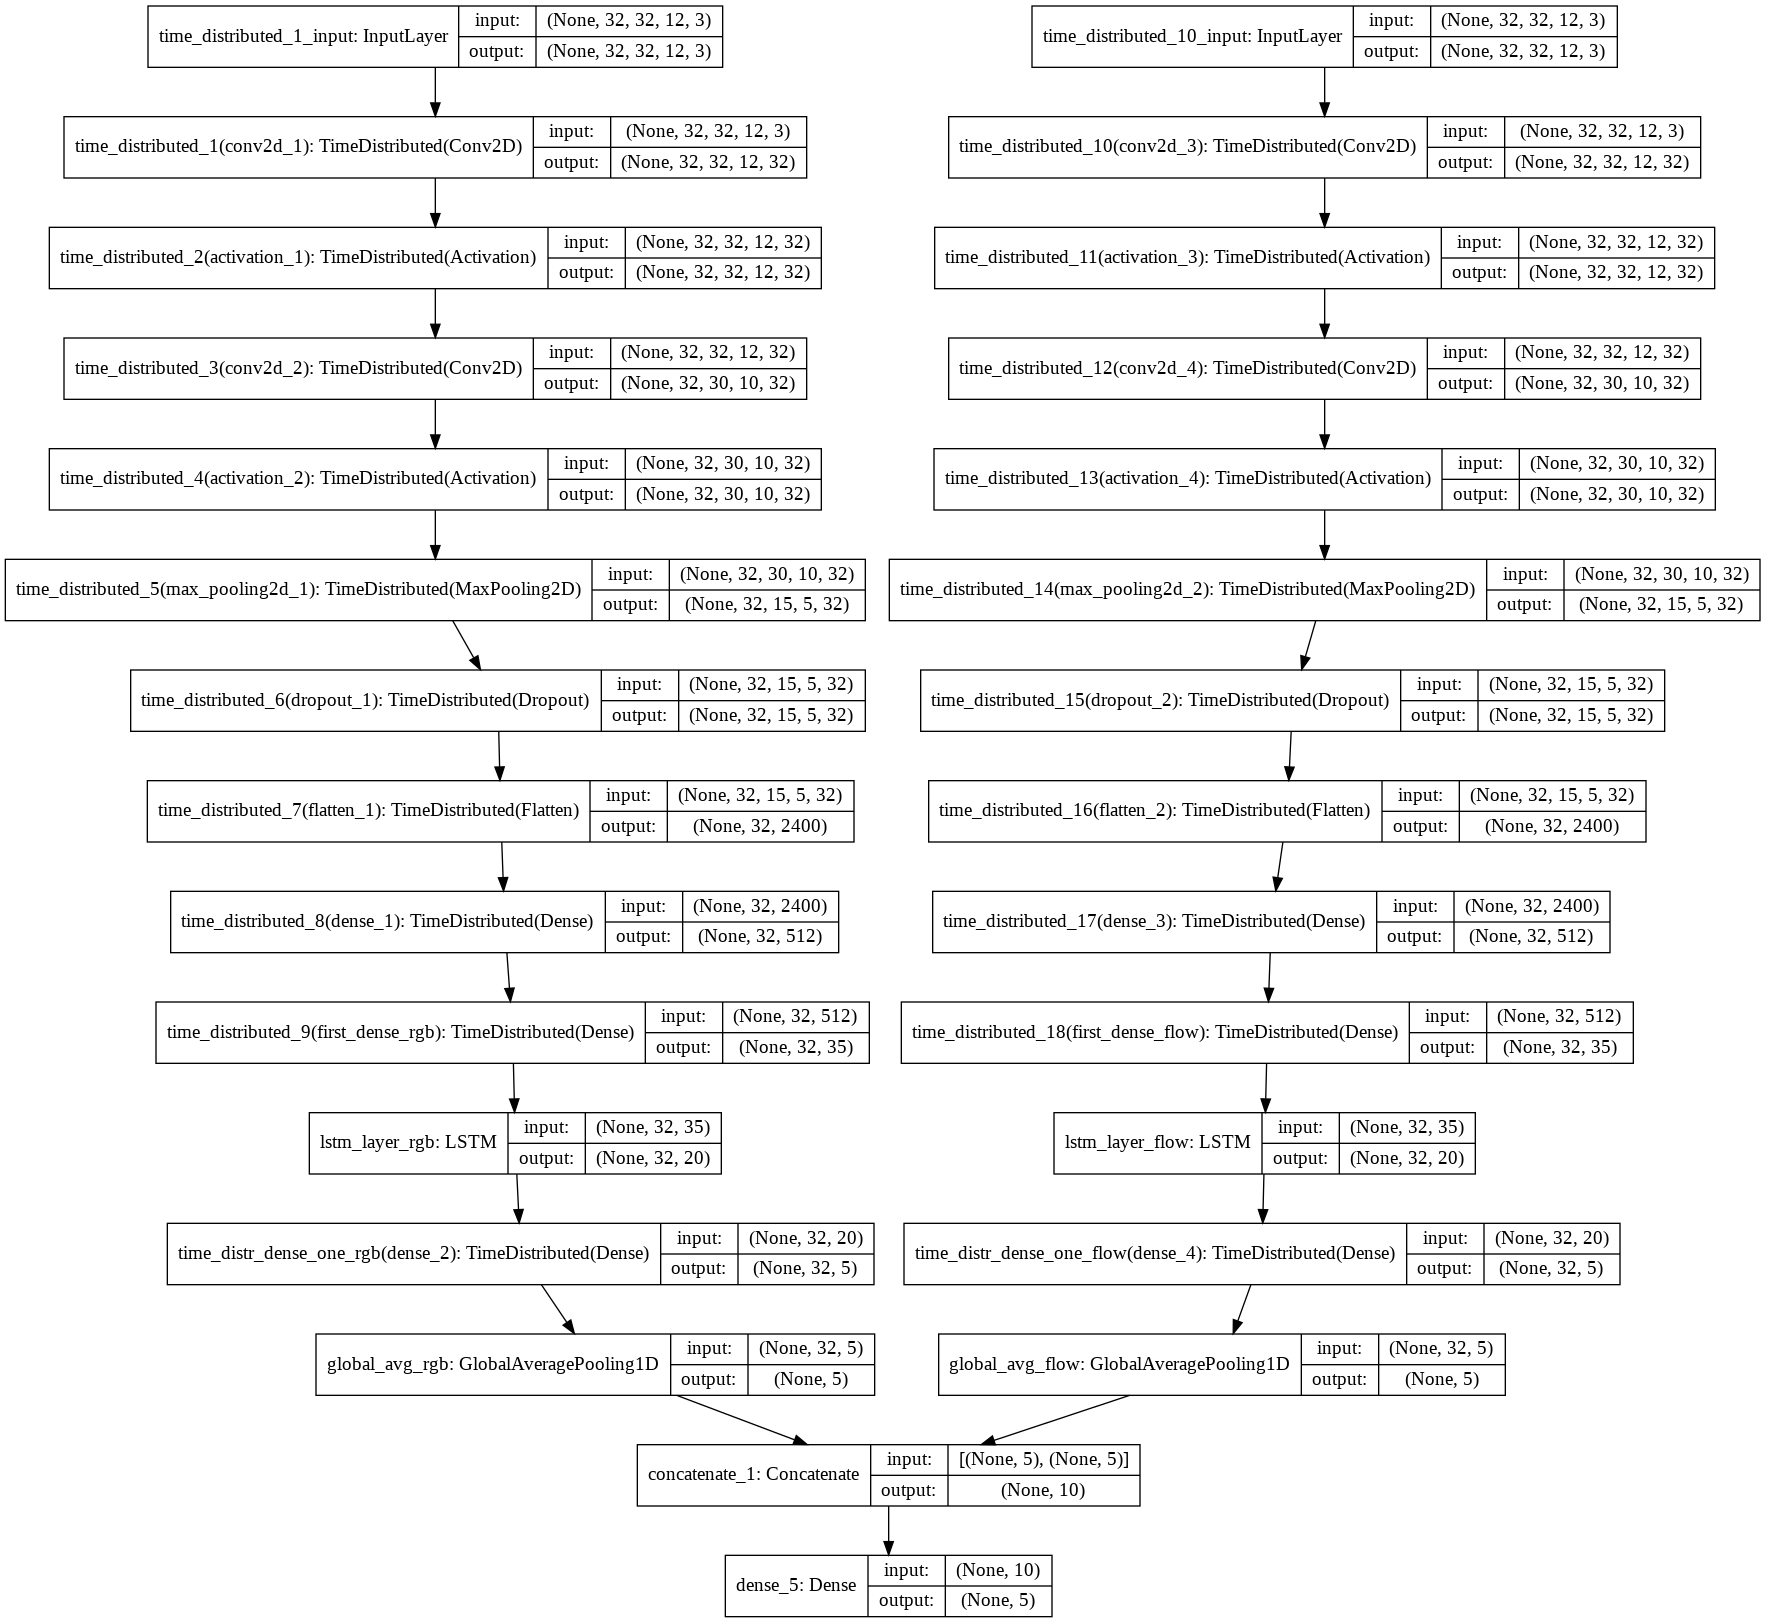

In [35]:
# Define model
def build_rgb_model():
    model=Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same'), input_shape=(X.shape[1:])))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(Conv2D(32, (3, 3))))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(512)))

    model.add(TimeDistributed(Dense(35, name="first_dense_rgb" )))

    model.add(LSTM(20, return_sequences=True, name="lstm_layer_rgb"));

    model.add(TimeDistributed(Dense(nb_classes), name="time_distr_dense_one_rgb"))
    model.add(GlobalAveragePooling1D(name="global_avg_rgb"))

    return model


def build_flow_model():
    model=Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same'), input_shape=(X.shape[1:])))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(Conv2D(32, (3, 3))))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(512)))

    model.add(TimeDistributed(Dense(35, name="first_dense_flow" )))

    model.add(LSTM(20, return_sequences=True, name="lstm_layer_flow"));

    model.add(TimeDistributed(Dense(nb_classes), name="time_distr_dense_one_flow"))
    model.add(GlobalAveragePooling1D(name="global_avg_flow"))

    return model

rgb_model = build_rgb_model()
flow_model = build_flow_model()

#model = Sequential()
#model.add(Concatenate([rgb_model, flow_model]))
#model.add(Average([rgb_model, flow_model]))
modeltmp = concatenate([rgb_model.output, flow_model.output], axis=-1)
# Merge
#merged = concatenate([rgb_model, flow_model])

# Dense
#dense_out = Dense(nb_classes, activation='softmax')(merged)

# build and compile model
#model = Model(inputs=[X, X], outputs=[dense_out])
modeltmp = Dense(nb_classes, activation='sigmoid')(modeltmp)
model = Model(inputs=[rgb_model.input, flow_model.input], outputs=modeltmp)
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
#model.build(X.shape[1:])
print("input shape",model.input_shape)
model.summary()
plot_model(model, show_shapes=True,
            to_file=os.path.join(args.output, 'model.png'))

In [36]:

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=43)
history = model.fit([X_train,X_train], Y_train, validation_data=([X_test,X_test], Y_test), batch_size=args.batch,epochs=args.epoch, verbose=1, shuffle=True)

Train on 1783 samples, validate on 446 samples
Epoch 1/500
1783/1783 [==============================] - 25s 14ms/step - loss: 1.1491 - accuracy: 0.4425 - val_loss: 1.0744 - val_accuracy: 0.4709
Epoch 2/500
1783/1783 [==============================] - 17s 9ms/step - loss: 1.0512 - accuracy: 0.4408 - val_loss: 1.0301 - val_accuracy: 0.4283
Epoch 3/500
1783/1783 [==============================] - 17s 9ms/step - loss: 1.0263 - accuracy: 0.4335 - val_loss: 1.0162 - val_accuracy: 0.4574
Epoch 4/500
1783/1783 [==============================] - 17s 10ms/step - loss: 1.0899 - accuracy: 0.4414 - val_loss: 1.0947 - val_accuracy: 0.4709
Epoch 5/500
1783/1783 [==============================] - 17s 9ms/step - loss: 1.0889 - accuracy: 0.4481 - val_loss: 1.0868 - val_accuracy: 0.4709
Epoch 6/500
1783/1783 [==============================] - 17s 9ms/step - loss: 1.0880 - accuracy: 0.4481 - val_loss: 1.0861 - val_accuracy: 0.4709
Epoch 7/500
1783/1783 [==============================] - 18s 10ms/step - lo

In [37]:
model.evaluate([X_test,X_test], Y_test, verbose=0)

[1.087184428366845, 0.4708520174026489]

In [0]:
model_json = model.to_json()
if not os.path.isdir(args.output):
    os.makedirs(args.output)
with open(os.path.join(args.output, 'model.json'), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(args.output, 'model.hd5'))


In [39]:
loss, acc = model.evaluate([X_test,X_test], Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 1.087184428366845
Test accuracy: 0.4708520174026489


In [0]:
save_history(history, args.output)

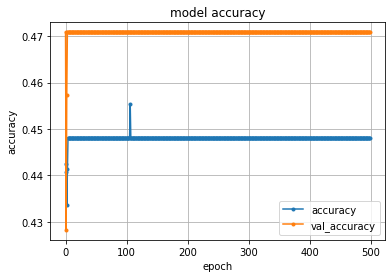

In [41]:
plt.plot(history.history['accuracy'], marker='.')
plt.plot(history.history['val_accuracy'], marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.savefig(os.path.join(args.output, 'model_accuracy.png'))
plt.show()

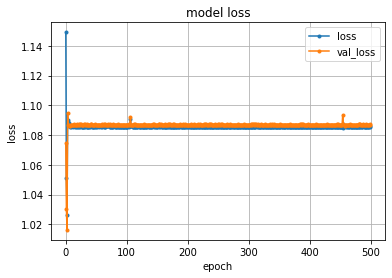

In [42]:
plt.plot(history.history['loss'], marker='.')
plt.plot(history.history['val_loss'], marker='.')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig(os.path.join(args.output, 'model_loss.png'))
plt.show()

In [43]:
# Prepare data for prediction
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
vid3d = Videoto3D(img_rows, img_cols, frames)
test_data = vid3d.video3d('/content/drive/My Drive/DL Internship/Dataset(videos)/Fight/VID-20200520-WA0032.mp4', color=args.color, skip=args.skip)
t = np.expand_dims(test_data, axis=0)
print(t.shape)
td = np.array(t).transpose((0, 2, 3, 1, 4))
print(td.shape)
ls = [test_data]

test  /content/drive/My Drive/DL Internship/Dataset(videos)/Fight/VID-20200520-WA0032.mp4


error: ignored

In [0]:
from keras.models import load_model
from keras.models import model_from_json
import json
with open(os.path.join(args.output, '3dcnnmodel.json'),'r') as f:
    print(type(f))
    for i in f:
      print(type(i))
      model_json = i
      break

model = model_from_json(model_json)
model.load_weights(os.path.join(args.output, '3dcnnmodel.hd5'))

In [0]:
# Predict.
predictions = model.predict(td)
print(predictions)

In [0]:
# Process predicted result
class_names = ['Waving both hands','Waving hand','Fight','Lying','Handshake']
class_names[np.argmax(predictions)]

In [0]:
def get_UCF_classname(filename):
  print(filename.find('_'))
  print(filename.find('_', ))
  return filename[filename.find('_') + 1:filename.find('_', 2)]

In [0]:
get_UCF_classname("Waving both hand")